In [1]:
# Importing necessary libraries

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('wordnet')

from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

import re
import string

import gensim
from gensim import models, corpora, similarities
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
import random
import collections

import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
cd "/content/drive/My Drive/Design Project"

/content/drive/My Drive/Design Project


In [4]:
train_data = pd.read_csv('preprocessed_train_data.csv')
test_data = pd.read_csv('preprocessed_test_data.csv')
valid_data = pd.read_csv('preprocessed_valid_data.csv')

#**XG Boost**

###**1.BOW**

In [ ]:
 #Select the features and the target
X = train_data["text_preprocessed"]
y = train_data["propaganda_label"]

In [ ]:
# checking for distribution of labels

y.value_counts(normalize=True)

-1    0.888262
 1    0.111738
Name: propaganda_label, dtype: float64

In [ ]:
from collections import Counter
counter = Counter(y)
counter

Counter({-1: 31965, 1: 4021})

- We can observe that the majority of the labels are from class -1 and only a few are from class 1.
- Since we’re using the Scikit-learn machine library, it has a XGBoost implementation that supports class weighting. Hence I am using the inbuilt parameter “scale_pos_weight” while creating an instance of the XGBoost classifier model.

In [ ]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

In [ ]:
# Setting the bag of words object

text_ext_bow = CountVectorizer(analyzer='word',
                                ngram_range=(1, 3),
                                stop_words="english",
                                min_df = 100,
                                max_df = 0.90)

In [ ]:
# Fitting the vectorizer with our training set

bow_train = text_ext_bow.fit_transform(X_train)


In [ ]:
# Now we can fit our test data with the same vectorizer

bow_test = text_ext_bow.transform(X_test)

In [ ]:
# Transforming categorical column

le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [ ]:
# XGBOOST classifer without using scale_pos_weight hyperparameter

xgb_clf = XGBClassifier(use_label_encoder = False,
                        eval_metric = "auc",
                        n_jobs = -1)

xgb_clf.fit(bow_train, y_train, verbose = False)


# Predict on test data
pred_test = xgb_clf.predict(bow_test)
y_pred = le.inverse_transform(pred_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.96      0.99      0.97      6394
           1       0.91      0.65      0.76       804

    accuracy                           0.95      7198
   macro avg       0.94      0.82      0.87      7198
weighted avg       0.95      0.95      0.95      7198



In [ ]:
# XGBOOST classifier using scale_pos_weight hyperparameter

# Counting examples in each class
counter = Counter(y)

# Estimating scale_pos_weight value
estimate = counter[-1] / counter[1]
print('Estimate: %.3f' % estimate)

xgb_clf = XGBClassifier(scale_pos_weight = estimate,
                        use_label_encoder = False,
                        eval_metric = "auc",
                        n_jobs = -1)

xgb_clf.fit(bow_train, y_train, verbose = False)


# Predict on test data
pred_test = xgb_clf.predict(bow_test)
y_pred = le.inverse_transform(pred_test)


# Print classification report
print(classification_report(y_test, y_pred))

Estimate: 7.950
              precision    recall  f1-score   support

          -1       0.97      0.97      0.97      6394
           1       0.75      0.79      0.77       804

    accuracy                           0.95      7198
   macro avg       0.86      0.88      0.87      7198
weighted avg       0.95      0.95      0.95      7198



In [ ]:
%%time

# Hyperparameter tuning

import joblib

# Creating model instance
xgb_clf = XGBClassifier()

# Estimating scale_pos_weight value
estimate = counter[-1] / counter[1]

# specifying all hyperparameters with possible values
param = {
    'scale_pos_weight': [estimate],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [0.1, 0.5, 1, 2, 3, 5, 8, 10],
    'subsample': [0.5, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 5, 10]
}

# Create 5 folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Hyperparameter tuning using RandomizedSearchCV
model = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param, scoring="f1", n_iter=10, cv=folds, verbose=2, return_train_score=True, random_state=50)

# Saving the trained model to a file
model_name = 'tuned_xgboost_model.pkl'
joblib.dump(model,model_name )


# Loading the model
model = joblib.load(model_name)

# Train model to learn relationships between x and y
model.fit(bow_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=200, reg_alpha=10, reg_lambda=0.5, scale_pos_weight=7.949515046008456, subsample=0.5; total time=  26.4s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=200, reg_alpha=10, reg_lambda=0.5, scale_pos_weight=7.949515046008456, subsample=0.5; total time=  24.8s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=200, reg_alpha=10, reg_lambda=0.5, scale_pos_weight=7.949515046008456, subsample=0.5; total time=  35.3s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=200, reg_alpha=10, reg_lambda=0.5, scale_pos_weight=7.949515046008456, subsample=0.5; total time=  45.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=200, reg_alpha=10, reg_lambda=0.5, scal

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [0.1, 0.5, 1, 2, 3,
                                                             5, 8, 10],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
                                        'reg_lambda': [0, 0.1, 0.5, 1, 5, 10],
                                        'scale_pos_weight': [7.949515046008456],
                                        'subsample': [0.5, 0.7, 0.8, 0.9]},
                   random_state=50, return_train_score=True, scoring='f1',
                   verbose=2)

In [ ]:
# printing best hyperparameters

print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.8089407025068418
Best hyperparameters:  {'subsample': 0.7, 'scale_pos_weight': 7.949515046008456, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


In [ ]:
%%time

# Hyperparameter tuning

# Creating model instance
xgb_clf = XGBClassifier()

# Estimating scale_pos_weight value
estimate = counter[-1] / counter[1]

# specifying all hyperparameters with possible values
param = {
    'scale_pos_weight': [estimate],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [0.1, 0.5, 1, 2, 3, 5, 8, 10],
    'subsample': [0.5, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300,500],
    'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 5, 10]
}

# Create 5 folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Hyperparameter tuning using RandomizedSearchCV
model = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param, scoring="f1", n_iter=20, cv=folds, verbose=2, return_train_score=True, random_state=50)


# Saving the trained model to a file
model_name = 'new_tuned_xgboost_model.pkl'
joblib.dump(model,model_name )


# Loading the model
model = joblib.load(model_name)

# Train model to learn relationships between x and y
model.fit(bow_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=0.5, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=1, reg_lambda=0.5, scale_pos_weight=7.949515046008456, subsample=0.5; total time=  24.2s
[CV] END colsample_bytree=0.5, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=1, reg_lambda=0.5, scale_pos_weight=7.949515046008456, subsample=0.5; total time=  21.3s
[CV] END colsample_bytree=0.5, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=1, reg_lambda=0.5, scale_pos_weight=7.949515046008456, subsample=0.5; total time=  27.7s
[CV] END colsample_bytree=0.5, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=1, reg_lambda=0.5, scale_pos_weight=7.949515046008456, subsample=0.5; total time=  21.9s
[CV] END colsample_bytree=0.5, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=1, reg_lambda=0.5, scale_po

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [0.1, 0.5, 1, 2, 3,
                                                             5, 8, 10],
                                        'n_estimators': [100, 200, 300, 500],
                                        'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
                                        'reg_lambda': [0, 0.1, 0.5, 1, 5, 10],
                                        'scale_pos_weight': [7.949515046008456],
                                        'subsample': [0.5, 0.7, 0.8, 0.9]},
                   random_state=50, return_train_score=True, scoring='f1',
                   verbose=2)

In [ ]:
# printing best hyperparameters

print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.8181870192181868
Best hyperparameters:  {'subsample': 0.9, 'scale_pos_weight': 7.949515046008456, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.7}


In [ ]:
# Building model again with best params

xg_best = XGBClassifier(subsample= 0.9, scale_pos_weight= 7.949515046008456, reg_lambda= 0, reg_alpha= 0.1, n_estimators= 500, min_child_weight= 10, max_depth= 6, learning_rate= 0.2, colsample_bytree= 0.7)
xg_best.fit(bow_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Train data performance

# Predict on test data
pred_test = xg_best.predict(bow_test)
y_pred = le.inverse_transform(pred_test)

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.97      0.98      0.98      6394
           1       0.85      0.78      0.82       804

    accuracy                           0.96      7198
   macro avg       0.91      0.88      0.90      7198
weighted avg       0.96      0.96      0.96      7198



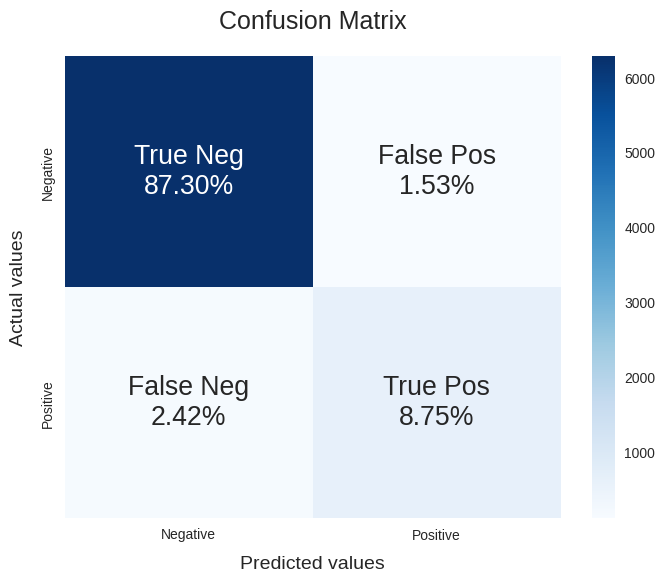



Classification Report

              precision    recall  f1-score   support

          -1       0.97      0.98      0.98      6394
           1       0.85      0.78      0.82       804

    accuracy                           0.96      7198
   macro avg       0.91      0.88      0.90      7198
weighted avg       0.96      0.96      0.96      7198


ROC AUC Score: 0.8831892305753063


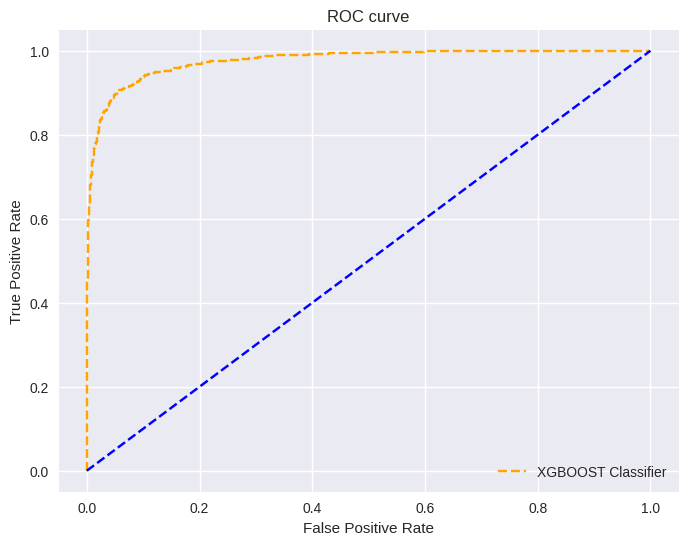

In [ ]:
# Evaluating the model on Training data

# Predicting the labels for train data
pred_test = xg_best.predict(bow_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(bow_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Checking validation data

valid_data.head()

,text_preprocessed,propaganda_label
0,"convened examine cause civil unrest black communities, presidential commission issued report stark conclusion: america moving towards two societies, ""one black, one white — separate unequal."" fifty year historic kerner commission identified ""white racism"" key cause ""pervasive discrimination employment, education housing,"" progress african american fare comparison white come homeownership, unemployment incarceration, according report economic policy institute released monday. cases, african american worse today civil right movement culminated law barring housing voter discrimination well ra...",-1
1,"discriminating someone basis sexual orientation prohibited federal civil right law, federal appeal court ruled monday sided gay skydiving instructor fired job discussing sexuality client. decision u.s. court appeal 2nd circuit offer expanded protection lgbt people mark significant loss president donald trump justice department, filed brief arguing title vii civil right act cover sexual orientation discrimination. state law still murky, federal circuit part country issued mixed opinions. ruling 2nd circuit, based manhattan, could appealed supreme court. justice department spokesman devin o'...",-1
2,"bill cosby year old daughter, ensa cosby, died massachusetts kidney disease, spokesman comedian said monday. spokesman andrew wyatt immediately offer detail death friday. ""please keep cosby family prayer give peace time,"" said. bill cosby lost another five child year old son, ennis, graduate student columbia university, shot death changing flat tire near freeway ramp los angeles. year old man later convicted sentenced life prison without parole. bill cosby, 80, owns home western massachusetts town shelburne falls. ensa cosby spoke father behalf trial last year charge drugged molested woman...",-1
3,"fast moving, powerful theatrical locomotive “murder orient express” hartford stage march 25, make stop syria, paris snowbound, tree lined landscape between. really want broadway. though character speak host top european accents, patter new york snappy. show’s designer broadway regular — costume designer extraordinaire william ivey long (a natural gig, done recent broadway revival “on twentieth century”), scenic designer beowulf boritt (“come away,” “meteor shower”), lighting designer ken billington (who worked boritt “sunday park george” “act one”), sound designer darron l. west (a regular...",-1
4,"friday. national pizza day. grab life slice. not? connecticut all. footing national pizza lore remains solid ever. hartford, option pie plentiful. new haven, even better — like thin slightly charred. hardest choice, without doubt, go. you’re bold, take tour. half dozen option you’re hartford area: angelina’s hartford. boast biggest slice around. true pizza detective needed investigate claim, likely won’t leave hungry. handout angelina is: prospect ave, hartford, ct angelina is: prospect ave, hartford, ct (handout) couple turn away, you’ve got lena’s first & last pizzaria hartford parkville...",-1


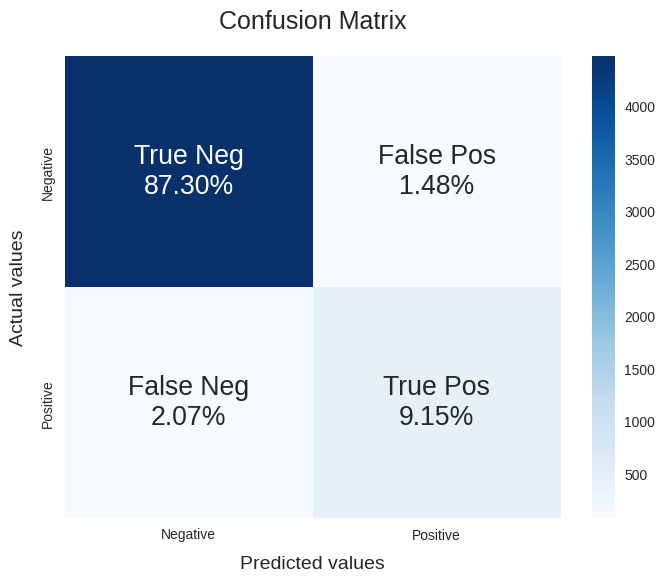



Classification Report

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98      4550
           1       0.86      0.82      0.84       575

    accuracy                           0.96      5125
   macro avg       0.92      0.90      0.91      5125
weighted avg       0.96      0.96      0.96      5125


ROC AUC Score: 0.8994744386048734


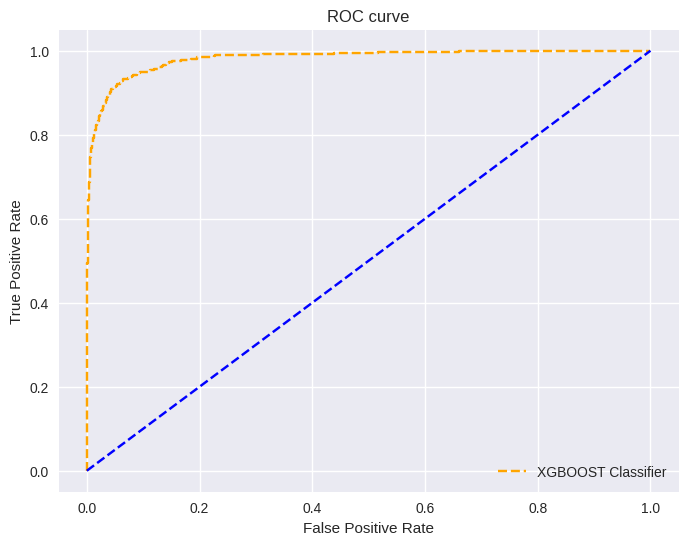

In [ ]:
# Evaluating the model on Validation dataset

# Transforming the validation data into bag-of-words format using the same vectorizer
bow_test = text_ext_bow.transform(valid_data.text_preprocessed)

# Changing the label name
y_test = valid_data.propaganda_label


# Predicting the labels for validation data
pred_test = xg_best.predict(bow_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(bow_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Checking test data

test_data.head()

,text_preprocessed,propaganda_label
0,"eat connecticut teamed end hunger connecticut (ehc) first ever 'culinary corner pub crawl,' jan. 20. crawl featured top blue back square pub restaurants. proceeds benefit ehc program outreach efforts. diner purchased special bracelets, entitled percent discount flora, vinted, india, cook bear, artisan restaurant. participant map stamped venue. jeannette dardenne, co owns eat connecticut, said crawl let community sample food drink west hartford premier restaurant support great cause. dardenne co owner kristen fritz founded social influencer group guide people fun activity supporting local c...",-1
1,"owner old pennsylvania power plant that’s target connecticut anti air pollution lawsuit reached deal sierra club stop burning coal facility peak summer ozone month starting 2023. agreement talen energy, owner high pollution brunner island generating facility, sierra club official halt burning coal power plant may september beginning start phase plan 2023. coal use year old plant ended consent decree, still need court approval. connecticut authority environmental group year demanding federal action clean pollution brunner island steam electric station. cite study showing emission plant drif...",-1
2,"majority owner president donald trump hotel latin america abruptly ordered trump employee property thursday, triggering confrontation trump employee refused leave asked police intervene, according trump organization local news reports. attempt takeover orestes fintiklis — cypriot businessman based miami — marked sharp escalation fintiklis month old effort brand trump international hotel panama replace trump organization manager. fintiklis blame trump brand trump company declining revenue empty rooms. but, far, tactic confined lawsuit angry letters. changed thursday, fintiklis group others ...",-1
3,"connecticut’s likely option using toll help fund transportation project involves “congestion pricing” system charge driver rush hour le peak times, according top state official. state could bring much $750 million year toll revenue using congestion pricing, according transportation commissioner james redeker. warned state commission last month would involve “tolling every interstate limited access [highway] state roads.” way achieve level revenue would put toll state roads, including route 2, 8, merritt parkway, redeker said december hearing commission fiscal stability economic growth. “we...",-1
4,"escaped prisoner jerry mercado back connecticut. year old hartford man escaped carl robinson correctional institution enfield jan. 7. housed northern correctional institution somers, known state’s supermax prison. mercado extradited canton, ga., held since arrest local police jan. 17. initially fought extradition, later waived right. caught, mercado bleached hair eyebrow made effort cover notorious neck tattoo reads: “time wait one.” department correction’s fugitive investigation unit, working concert u.s. marshal fugitive task force connecticut state police, developed intelligence placing...",-1


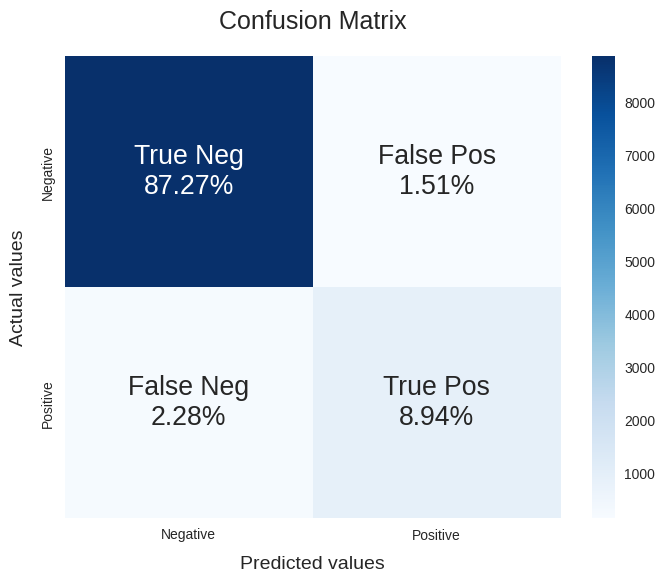



Classification Report

              precision    recall  f1-score   support

          -1       0.97      0.98      0.98      9019
           1       0.86      0.80      0.83      1140

    accuracy                           0.96     10159
   macro avg       0.92      0.89      0.90     10159
weighted avg       0.96      0.96      0.96     10159


ROC AUC Score: 0.8897635206766222


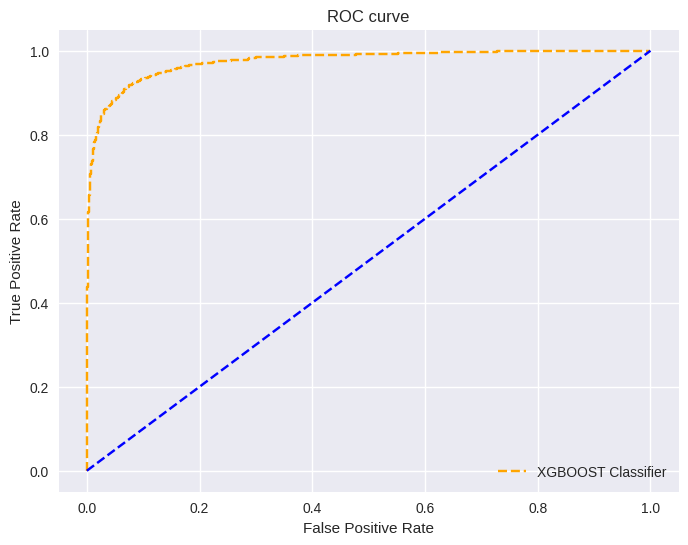

In [ ]:
# Evaluating the model on test dataset

# Transforming the test data into bag-of-words format using the same vectorizer
bow_test = text_ext_bow.transform(test_data.text_preprocessed)

# Changing the label name
y_test = test_data.propaganda_label

# Predicting the labels for test data
pred_test = xg_best.predict(bow_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(bow_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

###**2. TfIdf Vectorizer**

In [ ]:
 #Select the features and the target
X = train_data["text_preprocessed"]
y = train_data["propaganda_label"]

In [ ]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

In [ ]:
# Set an bog of words object
text_ext_tfidf = TfidfVectorizer(analyzer='word',
                                ngram_range=(1, 3),
                                stop_words="english",
                                min_df = 100,
                                max_df = 0.90)

# Extracting features using train data
text_ext_tfidf.fit(X_train)

TfidfVectorizer(max_df=0.9, min_df=100, ngram_range=(1, 3),
                stop_words='english')

In [ ]:
# Transforming valid and test datasets into TF-IDF encoded features

X_tfidf_train = text_ext_tfidf.transform(X_train)

X_tfidf_test = text_ext_tfidf.transform(X_test)

X_tfidf_train.shape, X_tfidf_test.shape

((28788, 10108), (7198, 10108))

In [ ]:
# Transforming categorical column

le = LabelEncoder()
y_train = le.fit_transform(y_train)

              precision    recall  f1-score   support

          -1       0.96      0.99      0.97      6394
           1       0.92      0.64      0.75       804

    accuracy                           0.95      7198
   macro avg       0.94      0.81      0.86      7198
weighted avg       0.95      0.95      0.95      7198



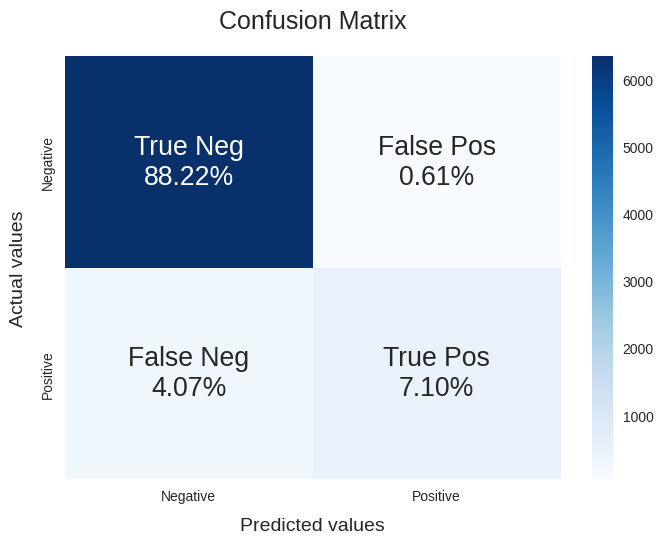

In [ ]:
# XGBOOST classifer without using scale_pos_weight hyperparameter

xgb_clf = XGBClassifier(use_label_encoder = False,
                        eval_metric = "auc",
                        n_jobs = -1)

xgb_clf.fit(X_tfidf_train, y_train)


# Predict on test data
pred_test = xgb_clf.predict(X_tfidf_test)
y_pred = le.inverse_transform(pred_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

              precision    recall  f1-score   support

          -1       0.97      0.97      0.97      6394
           1       0.79      0.78      0.79       804

    accuracy                           0.95      7198
   macro avg       0.88      0.88      0.88      7198
weighted avg       0.95      0.95      0.95      7198



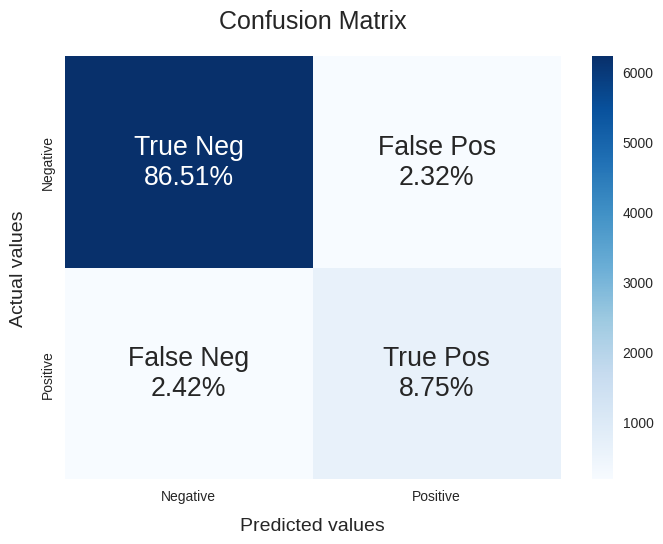

In [ ]:
# XGBOOST classifier using scale_pos_weight hyperparameter

from collections import Counter

# Counting examples in each class
counter = Counter(y)

# Estimating scale_pos_weight value
estimate = counter[-1] / counter[1]

xgb_clf = XGBClassifier(scale_pos_weight = estimate,
                        use_label_encoder = False,
                        eval_metric = "auc",
                        n_jobs = -1)

xgb_clf.fit(X_tfidf_train, y_train)


# Predict on test data
pred_test = xgb_clf.predict(X_tfidf_test)
y_pred = le.inverse_transform(pred_test)


# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [ ]:
%%time

from sklearn.pipeline import Pipeline
# Hyperparameter tuning

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("xgb", XGBClassifier())
])

# Counting examples in each class
counter = Counter(y)
# Estimating scale_pos_weight value
estimate = counter[-1] / counter[1]

# specifying all hyperparameters with possible values
param_grid = {
    "tfidf__min_df": (100, 150, 200),
    "tfidf__max_df": (0.5, 0.75, 0.9),
    "tfidf__ngram_range": ((1, 1), (1, 2),(1,3)),
    'xgb__scale_pos_weight': [estimate],
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'xgb__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'xgb__min_child_weight': [0.1, 0.5, 1, 2, 3, 5, 8, 10],
    'xgb__subsample': [0.5, 0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.5, 0.7, 0.8, 0.9],
    'xgb__n_estimators': [100, 200, 300,500],
    'xgb__reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
    'xgb__reg_lambda': [0, 0.1, 0.5, 1, 5, 10]
}

# Create 3 folds
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=30)

model = RandomizedSearchCV(pipeline, param_distributions=param_grid, scoring="f1", n_iter=10, cv=folds, verbose=2, random_state=50)

# Train model to learn relationships between x and y
model.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END tfidf__max_df=0.75, tfidf__min_df=200, tfidf__ngram_range=(1, 3), xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=0.5, xgb__n_estimators=100, xgb__reg_alpha=5, xgb__reg_lambda=5, xgb__scale_pos_weight=7.949515046008456, xgb__subsample=0.5; total time= 1.5min
[CV] END tfidf__max_df=0.75, tfidf__min_df=200, tfidf__ngram_range=(1, 3), xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=0.5, xgb__n_estimators=100, xgb__reg_alpha=5, xgb__reg_lambda=5, xgb__scale_pos_weight=7.949515046008456, xgb__subsample=0.5; total time= 1.5min
[CV] END tfidf__max_df=0.75, tfidf__min_df=200, tfidf__ngram_range=(1, 3), xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=0.5, xgb__n_estimators=100, xgb__reg_alpha=5, xgb__reg_lambda=5, xgb__scale_pos_weight=7.949515046008456, xgb__subsample=0.5; total time= 1.5min
[CV] E

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=30, shuffle=True),
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feat...
                                        'xgb__learning_rate': [0.01, 0.1, 0.2,
                                                               0.3],
                                        'xgb__max_depth': [3, 4, 5, 6, 7, 8, 9,
                                                           10],
                                        'xgb__min_child_weight': [0.1, 0.5, 1,
                                                                  2, 3, 5, 8,
                                                                  10],
                                        'xgb__n_estimators': [100, 200, 300,
                                                              500],
                                        'xgb__reg_alpha': [0, 0.1, 0.5, 1, 5,
                                                           10],
                                        'xgb__reg_lambda': [0, 0.1, 0.5, 1, 5,
                                                            10],
                                        'xgb__scale_pos_weight': [7.949515046008456],
                                        'xgb__subsample': [0.5, 0.7, 0.8, 0.9]},
                   random_state=50, scoring='f1', verbose=2)

In [ ]:
import os
path = "/content" # /content is pretty much the root

In [ ]:
cd "/content/drive/My Drive/Design Project"

/content/drive/My Drive/Design Project


In [ ]:
# Storing the best model for future use
best_model = model.best_estimator_

# Saving the best model to a file
joblib.dump(best_model, 'best_tfidf_xgboost_model.pkl')

['best_tfidf_xgboost_model.pkl']

In [ ]:
# Loading the model
import joblib

model = joblib.load('best_tfidf_xgboost_model.pkl')

In [ ]:
ls

 best_tfidf_xgboost_model.pkl                                    preprocessed_test_data.csv
'Design Project - ** 1. Pre-Processing.ipynb'                    preprocessed_train_data.csv
'Design Project - ** 2. Feature Engineering   Embedding.ipynb'   preprocessed_valid_data.csv
 Design_Project_Code_2_for_submission_ipynb.ipynb                proppy_1.0.dev.tsv
'google news vectors'                                            proppy_1.0.test.tsv
 GoogleNews-vectors-negative300.bin.gz                           proppy_1.0.train.tsv
 model_dir/                                                      tuned_xgboost_model.pkl
 new_tuned_xgboost_model.pkl


In [ ]:
best_model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, min_df=150, ngram_range=(1, 2))),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
best_model.named_steps['xgb'].get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 300,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'sampling_method': None,
 'scale_pos_weight': 7.949515046008456,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

# Setting an tfidf of words object
text_ext_tfidf = TfidfVectorizer(analyzer='word',
                                ngram_range=(1, 2),
                                stop_words="english",
                                min_df = 150,
                                max_df = 0.75)

# Extracting features using train data
text_ext_tfidf.fit(X_train)

TfidfVectorizer(max_df=0.75, min_df=150, ngram_range=(1, 2),
                stop_words='english')

In [ ]:
# Transforming valid and test datasets into TF-IDF encoded features

X_tfidf_train = text_ext_tfidf.transform(X_train)

X_tfidf_test = text_ext_tfidf.transform(X_test)

X_tfidf_train.shape, X_tfidf_test.shape

((28788, 6728), (7198, 6728))

In [ ]:
# Transforming categorical column

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [ ]:
# Building model again with best params

from xgboost import XGBClassifier

xg_best = XGBClassifier(subsample= 0.8, scale_pos_weight= 7.949515046008456, reg_lambda= 1, reg_alpha= 0.1, n_estimators= 300, min_child_weight= 3, max_depth= 10, learning_rate= 0.1, colsample_bytree= 0.9)

xg_best.fit(X_tfidf_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

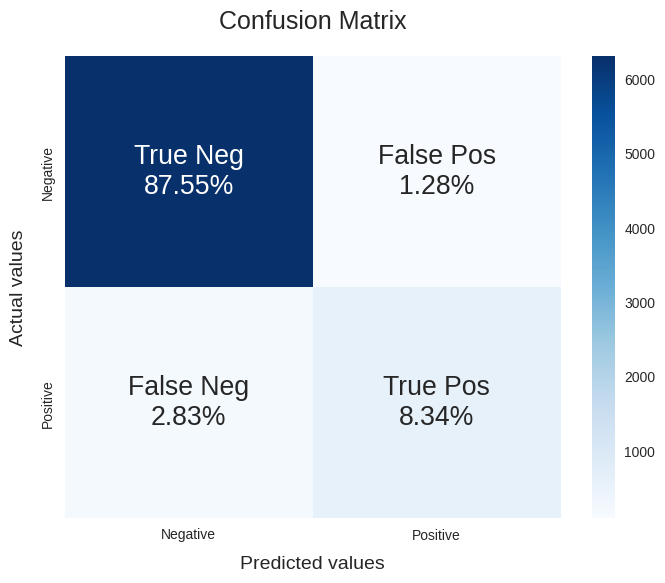



Classification Report

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      6394
           1       0.87      0.75      0.80       804

    accuracy                           0.96      7198
   macro avg       0.92      0.87      0.89      7198
weighted avg       0.96      0.96      0.96      7198


ROC AUC Score: 0.8659400837538923


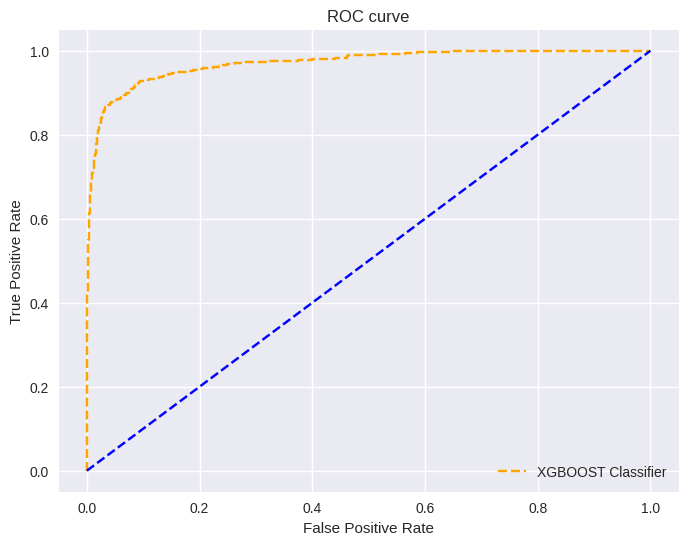

In [ ]:
# Evaluating the model on Training data

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# Predicting the labels for train data
pred_test = xg_best.predict(X_tfidf_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_tfidf_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Checking validation data

valid_data.head()

,text_preprocessed,propaganda_label
0,"convened examine cause civil unrest black communities, presidential commission issued report stark conclusion: america moving towards two societies, ""one black, one white — separate unequal."" fifty year historic kerner commission identified ""white racism"" key cause ""pervasive discrimination employment, education housing,"" progress african american fare comparison white come homeownership, unemployment incarceration, according report economic policy institute released monday. cases, african american worse today civil right movement culminated law barring housing voter discrimination well ra...",-1
1,"discriminating someone basis sexual orientation prohibited federal civil right law, federal appeal court ruled monday sided gay skydiving instructor fired job discussing sexuality client. decision u.s. court appeal 2nd circuit offer expanded protection lgbt people mark significant loss president donald trump justice department, filed brief arguing title vii civil right act cover sexual orientation discrimination. state law still murky, federal circuit part country issued mixed opinions. ruling 2nd circuit, based manhattan, could appealed supreme court. justice department spokesman devin o'...",-1
2,"bill cosby year old daughter, ensa cosby, died massachusetts kidney disease, spokesman comedian said monday. spokesman andrew wyatt immediately offer detail death friday. ""please keep cosby family prayer give peace time,"" said. bill cosby lost another five child year old son, ennis, graduate student columbia university, shot death changing flat tire near freeway ramp los angeles. year old man later convicted sentenced life prison without parole. bill cosby, 80, owns home western massachusetts town shelburne falls. ensa cosby spoke father behalf trial last year charge drugged molested woman...",-1
3,"fast moving, powerful theatrical locomotive “murder orient express” hartford stage march 25, make stop syria, paris snowbound, tree lined landscape between. really want broadway. though character speak host top european accents, patter new york snappy. show’s designer broadway regular — costume designer extraordinaire william ivey long (a natural gig, done recent broadway revival “on twentieth century”), scenic designer beowulf boritt (“come away,” “meteor shower”), lighting designer ken billington (who worked boritt “sunday park george” “act one”), sound designer darron l. west (a regular...",-1
4,"friday. national pizza day. grab life slice. not? connecticut all. footing national pizza lore remains solid ever. hartford, option pie plentiful. new haven, even better — like thin slightly charred. hardest choice, without doubt, go. you’re bold, take tour. half dozen option you’re hartford area: angelina’s hartford. boast biggest slice around. true pizza detective needed investigate claim, likely won’t leave hungry. handout angelina is: prospect ave, hartford, ct angelina is: prospect ave, hartford, ct (handout) couple turn away, you’ve got lena’s first & last pizzaria hartford parkville...",-1


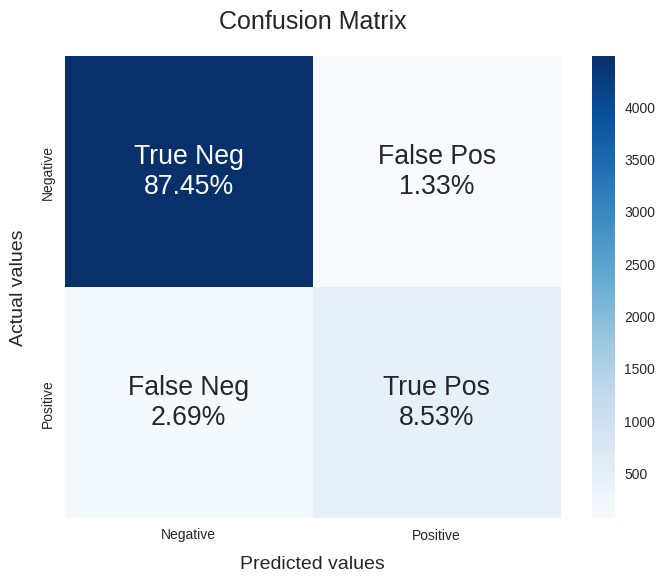



Classification Report

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      4550
           1       0.87      0.76      0.81       575

    accuracy                           0.96      5125
   macro avg       0.92      0.87      0.89      5125
weighted avg       0.96      0.96      0.96      5125


ROC AUC Score: 0.8725274725274725


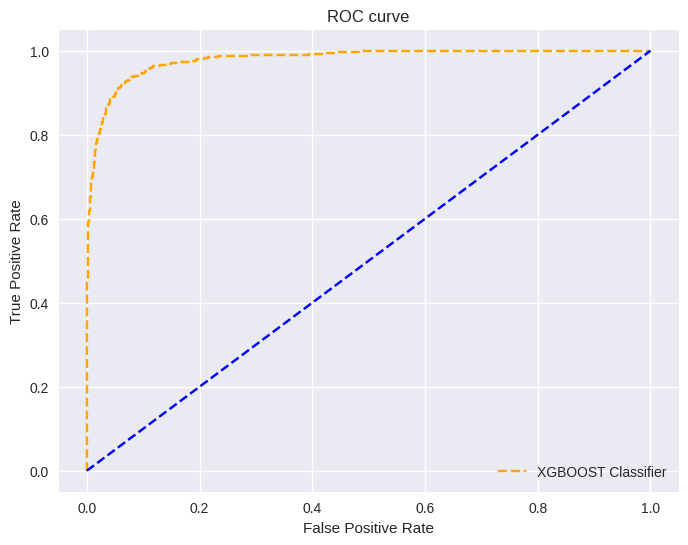

In [ ]:
# Evaluating the model on Validation dataset

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Transforming the validation data into bag-of-words format using the same vectorizer
X_tfidf_test = text_ext_tfidf.transform(valid_data.text_preprocessed)

# Changing the label name
y_test = valid_data.propaganda_label


# Predicting the labels for validation data
pred_test = xg_best.predict(X_tfidf_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_tfidf_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Checking test data

test_data.head()

,text_preprocessed,propaganda_label
0,"eat connecticut teamed end hunger connecticut (ehc) first ever 'culinary corner pub crawl,' jan. 20. crawl featured top blue back square pub restaurants. proceeds benefit ehc program outreach efforts. diner purchased special bracelets, entitled percent discount flora, vinted, india, cook bear, artisan restaurant. participant map stamped venue. jeannette dardenne, co owns eat connecticut, said crawl let community sample food drink west hartford premier restaurant support great cause. dardenne co owner kristen fritz founded social influencer group guide people fun activity supporting local c...",-1
1,"owner old pennsylvania power plant that’s target connecticut anti air pollution lawsuit reached deal sierra club stop burning coal facility peak summer ozone month starting 2023. agreement talen energy, owner high pollution brunner island generating facility, sierra club official halt burning coal power plant may september beginning start phase plan 2023. coal use year old plant ended consent decree, still need court approval. connecticut authority environmental group year demanding federal action clean pollution brunner island steam electric station. cite study showing emission plant drif...",-1
2,"majority owner president donald trump hotel latin america abruptly ordered trump employee property thursday, triggering confrontation trump employee refused leave asked police intervene, according trump organization local news reports. attempt takeover orestes fintiklis — cypriot businessman based miami — marked sharp escalation fintiklis month old effort brand trump international hotel panama replace trump organization manager. fintiklis blame trump brand trump company declining revenue empty rooms. but, far, tactic confined lawsuit angry letters. changed thursday, fintiklis group others ...",-1
3,"connecticut’s likely option using toll help fund transportation project involves “congestion pricing” system charge driver rush hour le peak times, according top state official. state could bring much $750 million year toll revenue using congestion pricing, according transportation commissioner james redeker. warned state commission last month would involve “tolling every interstate limited access [highway] state roads.” way achieve level revenue would put toll state roads, including route 2, 8, merritt parkway, redeker said december hearing commission fiscal stability economic growth. “we...",-1
4,"escaped prisoner jerry mercado back connecticut. year old hartford man escaped carl robinson correctional institution enfield jan. 7. housed northern correctional institution somers, known state’s supermax prison. mercado extradited canton, ga., held since arrest local police jan. 17. initially fought extradition, later waived right. caught, mercado bleached hair eyebrow made effort cover notorious neck tattoo reads: “time wait one.” department correction’s fugitive investigation unit, working concert u.s. marshal fugitive task force connecticut state police, developed intelligence placing...",-1


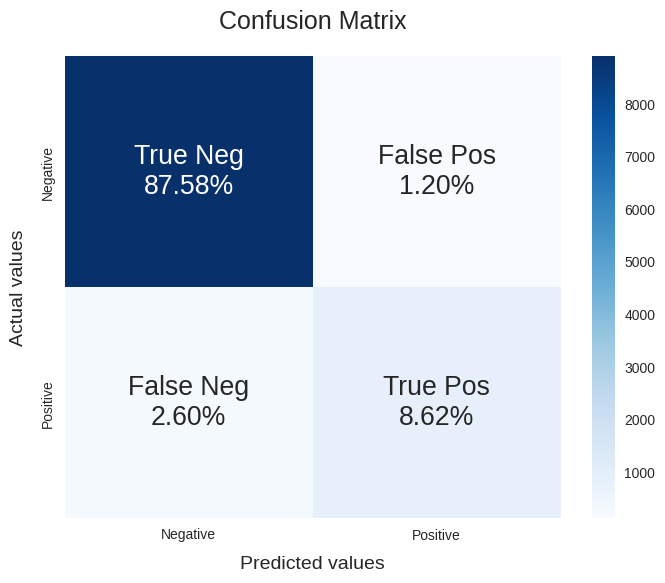



Classification Report

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      9019
           1       0.88      0.77      0.82      1140

    accuracy                           0.96     10159
   macro avg       0.92      0.88      0.90     10159
weighted avg       0.96      0.96      0.96     10159


ROC AUC Score: 0.8774470270364902


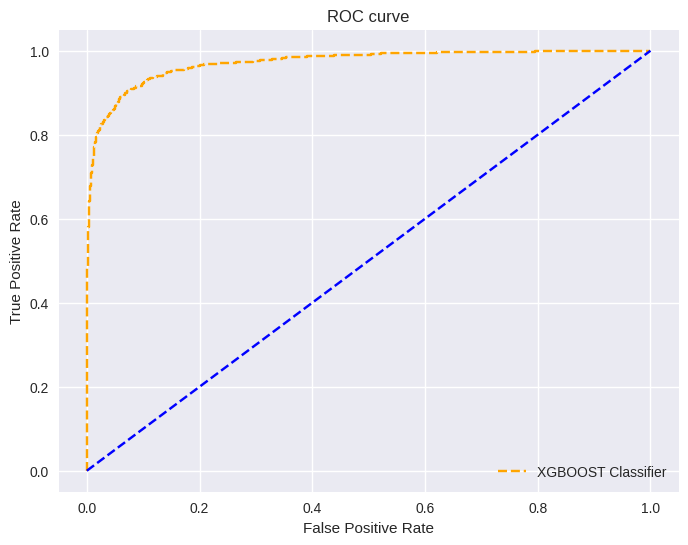

In [ ]:
# Evaluating the model on test dataset

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Transforming the test data into bag-of-words format using the same vectorizer
X_tfidf_test = text_ext_tfidf.transform(test_data.text_preprocessed)

# Changing the label name
y_test = test_data.propaganda_label

# Predicting the labels for test data
pred_test = xg_best.predict(X_tfidf_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_tfidf_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

###**3. Word2Vec**

In [ ]:
 #Select the features and the target
X = train_data["text_preprocessed"]
y = train_data["propaganda_label"]

In [ ]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

In [ ]:
# Creating train/test list of sentences

train_articles = [sentence.split() for sentence in X_train]
test_articles = [sentence.split() for sentence in X_test]

In [ ]:
# training Word2Vectors

w2v_model = Word2Vec(train_articles, min_count=5, vector_size=50, workers=-1) # considering only words that occured atleast 5 times

print(w2v_model.wv.most_similar('trump'))

print('='*100)

print(w2v_model.wv.most_similar('economy'))

[('reuters', 0.5417647957801819), ('learning', 0.5342778563499451), ('tricking', 0.509909451007843), ('spite', 0.49874505400657654), ('moreno', 0.48862141370773315), ('newark', 0.487811803817749), ('analogy', 0.47630465030670166), ('surname', 0.47482389211654663), ('imago', 0.474642276763916), ('liquidated', 0.46862030029296875)]
[('arabiyanet', 0.5285916924476624), ('episcopacy', 0.5268168449401855), ('standoff', 0.5043067336082458), ('thoroughfare', 0.49849212169647217), ('stockbridge', 0.49277597665786743), ('stanton', 0.49129483103752136), ('nashwauk', 0.48784542083740234), ('indoor', 0.4865754544734955), ('reminded', 0.4852547347545624), ('sabotage', 0.48399677872657776)]


In [ ]:
w2v_words = list(w2v_model.wv.index_to_key)

print("number of words that occured minimum 5 times ", len(w2v_words))

print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  50565
sample words  ['said', 'year', 'u', 'trump', 'state', 'would', 'one', 'also', 'people', 'president', 'time', 'new', 'government', 'country', 'two', 'last', 'say', 'day', 'could', 'first', 'like', 'may', 'right', 'police', 'told', 'school', 'house', 'official', 'law', 'according', 'iran', 'court', 'group', 'american', 'news', 'many', 'even', 'party', 'make', 'report', 'minister', 'israel', 'week', 'world', 'get', 'made', 'case', 'north', 'city', 'month']


In [ ]:
# Transforming preprocessed text data into Word2Vec encoded features

import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_w2v_train = np.array([vectorize(sentence) for sentence in X_train])
X_w2v_test = np.array([vectorize(sentence) for sentence in X_test])

X_w2v_train.shape, X_w2v_test.shape

((28788, 50), (7198, 50))

In [ ]:
# Transforming the target column

le = LabelEncoder()
y_train = le.fit_transform(y_train)

              precision    recall  f1-score   support

          -1       0.91      0.98      0.94      6394
           1       0.56      0.19      0.29       804

    accuracy                           0.89      7198
   macro avg       0.73      0.59      0.61      7198
weighted avg       0.87      0.89      0.87      7198



Text(0.5, 1.0, 'Confusion Matrix')

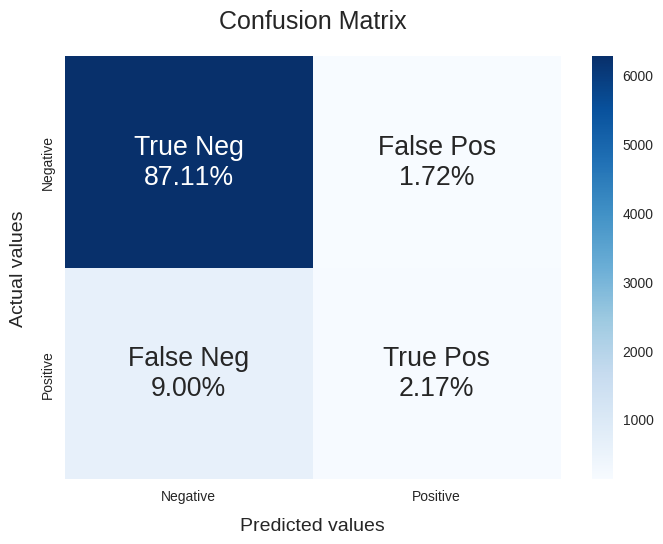

In [ ]:
# XGBOOST classifer without using scale_pos_weight hyperparameter

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


xgb_clf = XGBClassifier(eval_metric = "auc",
                        n_jobs = -1)

xgb_clf.fit(X_w2v_train, y_train)


# Predict on test data
pred_test = xgb_clf.predict(X_w2v_test)
y_pred = le.inverse_transform(pred_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      6394
           1       0.36      0.47      0.41       804

    accuracy                           0.85      7198
   macro avg       0.65      0.68      0.66      7198
weighted avg       0.87      0.85      0.86      7198



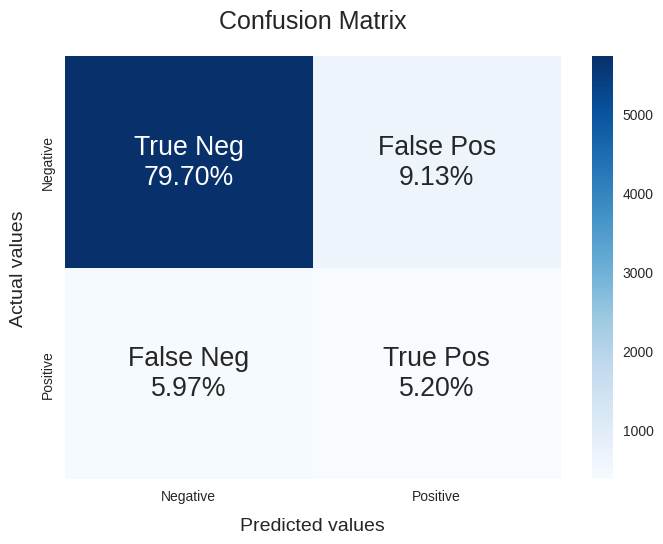

In [ ]:
# XGBOOST classifier using scale_pos_weight hyperparameter

from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from collections import Counter

# Counting examples in each class
counter = Counter(y)

# Estimating scale_pos_weight value
estimate = counter[-1] / counter[1]

xgb_clf = XGBClassifier(scale_pos_weight = estimate,
                        eval_metric = "auc",
                        n_jobs = -1)

xgb_clf.fit(X_w2v_train, y_train)


# Predict on test data
pred_test = xgb_clf.predict(X_w2v_test)
y_pred = le.inverse_transform(pred_test)


# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [ ]:
%%time

# Hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
from tqdm import tqdm  # Import tqdm
import joblib

# Creating model instance
xgb_clf = XGBClassifier()

# Estimating scale_pos_weight value
estimate = counter[-1] / counter[1]

# specifying all hyperparameters with possible values
param = {
    'scale_pos_weight': [estimate],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [0.1, 0.5, 1, 2, 3, 5, 8, 10],
    'subsample': [0.5, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300,500],
    'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 5, 10]
}

# Create 5 folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Hyperparameter tuning using RandomizedSearchCV
model = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param, scoring="f1", n_iter=10, cv=folds, verbose=2, n_jobs=-1, return_train_score=True, random_state=50)

# Train model to learn relationships between x and y
model.fit(X_w2v_train, y_train)

# Saving the trained model to a file
model_name = 'w2v_tuned_xgboost_model.pkl'
joblib.dump(model,model_name )

# Loading the model
model = joblib.load(model_name)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 6.35 s, sys: 601 ms, total: 6.96 s
Wall time: 3min 18s


In [ ]:
ls

 best_tfidf_xgboost_model.pkl                                    preprocessed_test_data.csv
'Design Project - ** 1. Pre-Processing.ipynb'                    preprocessed_train_data.csv
'Design Project - ** 2. Feature Engineering   Embedding.ipynb'   preprocessed_valid_data.csv
 Design_Project_Code_2_for_submission_ipynb.ipynb                proppy_1.0.dev.tsv
'google news vectors'                                            proppy_1.0.test.tsv
 GoogleNews-vectors-negative300.bin.gz                           proppy_1.0.train.tsv
 model_dir/                                                      tuned_xgboost_model.pkl
 new_tuned_xgboost_model.pkl                                     w2v_tuned_xgboost_model.pkl


In [ ]:
# printing best hyperparameters

print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.4298141533772598
Best hyperparameters:  {'subsample': 0.7, 'scale_pos_weight': 7.949515046008456, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [ ]:
# Building model again with best params

xg_best = XGBClassifier(subsample= 0.7, scale_pos_weight= 7.949515046008456, reg_lambda= 10, reg_alpha= 0.1, n_estimators= 100, min_child_weight= 2, max_depth= 7, learning_rate= 0.1, colsample_bytree= 0.9)

xg_best.fit(X_w2v_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

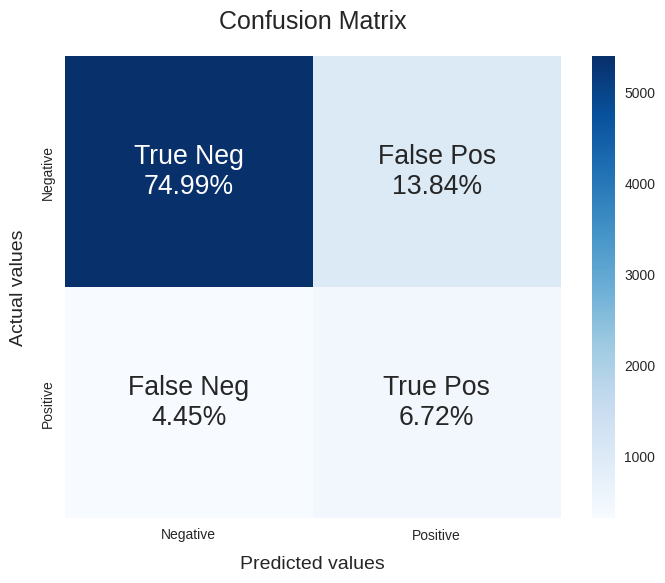



Classification Report

              precision    recall  f1-score   support

          -1       0.94      0.84      0.89      6394
           1       0.33      0.60      0.42       804

    accuracy                           0.82      7198
   macro avg       0.64      0.72      0.66      7198
weighted avg       0.88      0.82      0.84      7198


ROC AUC Score: 0.7231095072028036


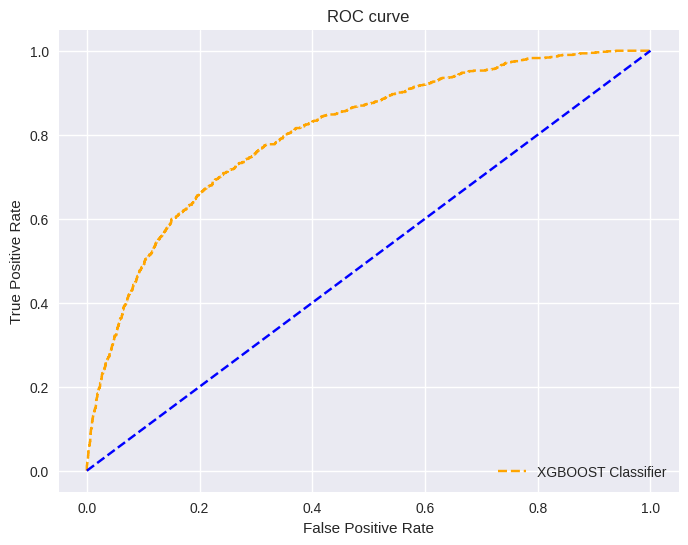

In [ ]:
# Evaluating the model on Training data

# Predicting the labels for train data
pred_test = xg_best.predict(X_w2v_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Checking validation data

valid_data.head()

,text_preprocessed,propaganda_label
0,"convened examine cause civil unrest black communities, presidential commission issued report stark conclusion: america moving towards two societies, ""one black, one white — separate unequal."" fifty year historic kerner commission identified ""white racism"" key cause ""pervasive discrimination employment, education housing,"" progress african american fare comparison white come homeownership, unemployment incarceration, according report economic policy institute released monday. cases, african american worse today civil right movement culminated law barring housing voter discrimination well ra...",-1
1,"discriminating someone basis sexual orientation prohibited federal civil right law, federal appeal court ruled monday sided gay skydiving instructor fired job discussing sexuality client. decision u.s. court appeal 2nd circuit offer expanded protection lgbt people mark significant loss president donald trump justice department, filed brief arguing title vii civil right act cover sexual orientation discrimination. state law still murky, federal circuit part country issued mixed opinions. ruling 2nd circuit, based manhattan, could appealed supreme court. justice department spokesman devin o'...",-1
2,"bill cosby year old daughter, ensa cosby, died massachusetts kidney disease, spokesman comedian said monday. spokesman andrew wyatt immediately offer detail death friday. ""please keep cosby family prayer give peace time,"" said. bill cosby lost another five child year old son, ennis, graduate student columbia university, shot death changing flat tire near freeway ramp los angeles. year old man later convicted sentenced life prison without parole. bill cosby, 80, owns home western massachusetts town shelburne falls. ensa cosby spoke father behalf trial last year charge drugged molested woman...",-1
3,"fast moving, powerful theatrical locomotive “murder orient express” hartford stage march 25, make stop syria, paris snowbound, tree lined landscape between. really want broadway. though character speak host top european accents, patter new york snappy. show’s designer broadway regular — costume designer extraordinaire william ivey long (a natural gig, done recent broadway revival “on twentieth century”), scenic designer beowulf boritt (“come away,” “meteor shower”), lighting designer ken billington (who worked boritt “sunday park george” “act one”), sound designer darron l. west (a regular...",-1
4,"friday. national pizza day. grab life slice. not? connecticut all. footing national pizza lore remains solid ever. hartford, option pie plentiful. new haven, even better — like thin slightly charred. hardest choice, without doubt, go. you’re bold, take tour. half dozen option you’re hartford area: angelina’s hartford. boast biggest slice around. true pizza detective needed investigate claim, likely won’t leave hungry. handout angelina is: prospect ave, hartford, ct angelina is: prospect ave, hartford, ct (handout) couple turn away, you’ve got lena’s first & last pizzaria hartford parkville...",-1


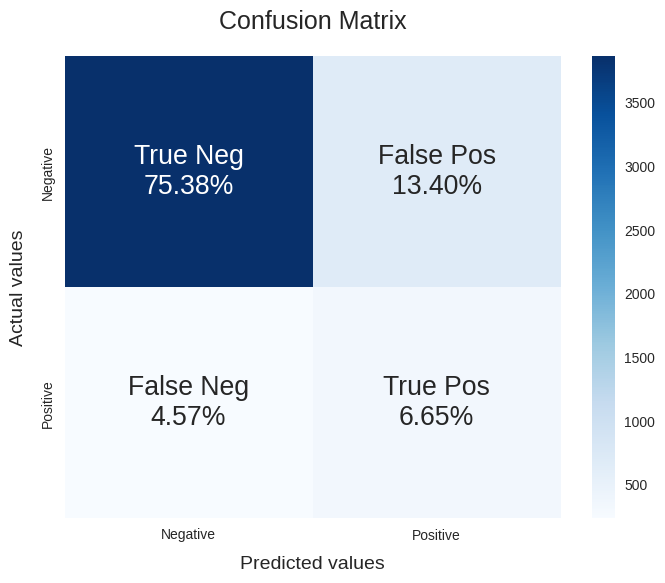



Classification Report

              precision    recall  f1-score   support

          -1       0.94      0.85      0.89      4550
           1       0.33      0.59      0.43       575

    accuracy                           0.82      5125
   macro avg       0.64      0.72      0.66      5125
weighted avg       0.87      0.82      0.84      5125


ROC AUC Score: 0.7210272336359292


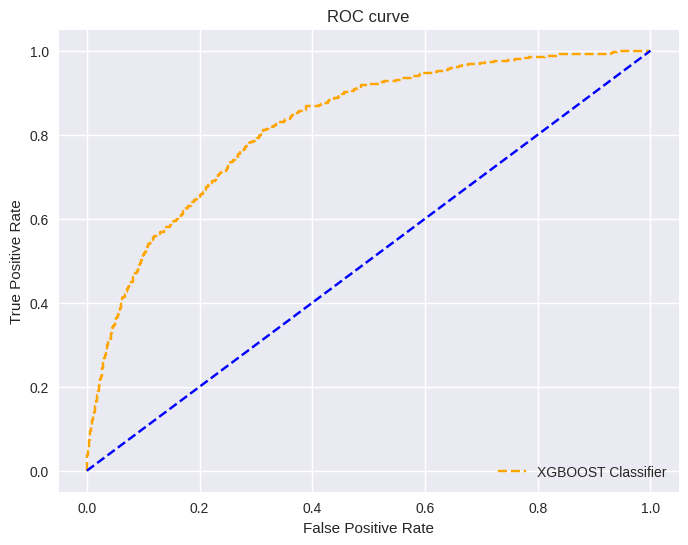

In [ ]:
# Evaluating the model on Validation dataset

# Transforming the validation data into word2vec format using the same vectorizer
X_w2v_test = np.array([vectorize(sentence) for sentence in valid_data.text_preprocessed])

# Changing the label name
y_test = valid_data.propaganda_label


# Predicting the labels for validation data
pred_test = xg_best.predict(X_w2v_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Checking test data

test_data.head()

,text_preprocessed,propaganda_label
0,"eat connecticut teamed end hunger connecticut (ehc) first ever 'culinary corner pub crawl,' jan. 20. crawl featured top blue back square pub restaurants. proceeds benefit ehc program outreach efforts. diner purchased special bracelets, entitled percent discount flora, vinted, india, cook bear, artisan restaurant. participant map stamped venue. jeannette dardenne, co owns eat connecticut, said crawl let community sample food drink west hartford premier restaurant support great cause. dardenne co owner kristen fritz founded social influencer group guide people fun activity supporting local c...",-1
1,"owner old pennsylvania power plant that’s target connecticut anti air pollution lawsuit reached deal sierra club stop burning coal facility peak summer ozone month starting 2023. agreement talen energy, owner high pollution brunner island generating facility, sierra club official halt burning coal power plant may september beginning start phase plan 2023. coal use year old plant ended consent decree, still need court approval. connecticut authority environmental group year demanding federal action clean pollution brunner island steam electric station. cite study showing emission plant drif...",-1
2,"majority owner president donald trump hotel latin america abruptly ordered trump employee property thursday, triggering confrontation trump employee refused leave asked police intervene, according trump organization local news reports. attempt takeover orestes fintiklis — cypriot businessman based miami — marked sharp escalation fintiklis month old effort brand trump international hotel panama replace trump organization manager. fintiklis blame trump brand trump company declining revenue empty rooms. but, far, tactic confined lawsuit angry letters. changed thursday, fintiklis group others ...",-1
3,"connecticut’s likely option using toll help fund transportation project involves “congestion pricing” system charge driver rush hour le peak times, according top state official. state could bring much $750 million year toll revenue using congestion pricing, according transportation commissioner james redeker. warned state commission last month would involve “tolling every interstate limited access [highway] state roads.” way achieve level revenue would put toll state roads, including route 2, 8, merritt parkway, redeker said december hearing commission fiscal stability economic growth. “we...",-1
4,"escaped prisoner jerry mercado back connecticut. year old hartford man escaped carl robinson correctional institution enfield jan. 7. housed northern correctional institution somers, known state’s supermax prison. mercado extradited canton, ga., held since arrest local police jan. 17. initially fought extradition, later waived right. caught, mercado bleached hair eyebrow made effort cover notorious neck tattoo reads: “time wait one.” department correction’s fugitive investigation unit, working concert u.s. marshal fugitive task force connecticut state police, developed intelligence placing...",-1


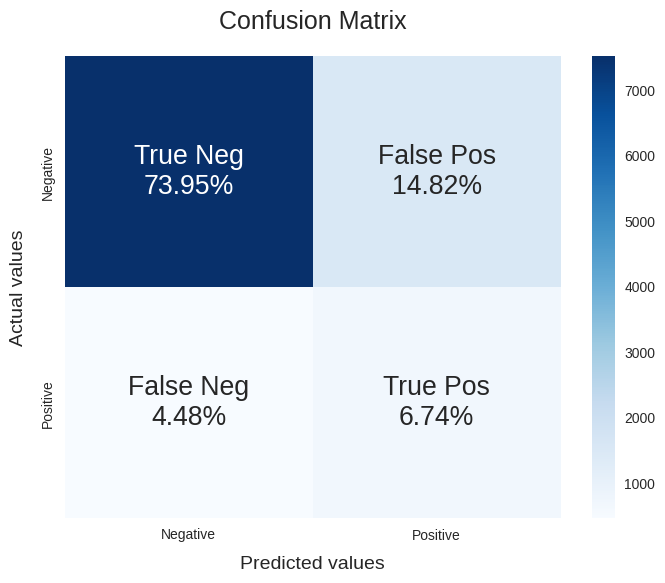



Classification Report

              precision    recall  f1-score   support

          -1       0.94      0.83      0.88      9019
           1       0.31      0.60      0.41      1140

    accuracy                           0.81     10159
   macro avg       0.63      0.72      0.65     10159
weighted avg       0.87      0.81      0.83     10159


ROC AUC Score: 0.7169481873549601


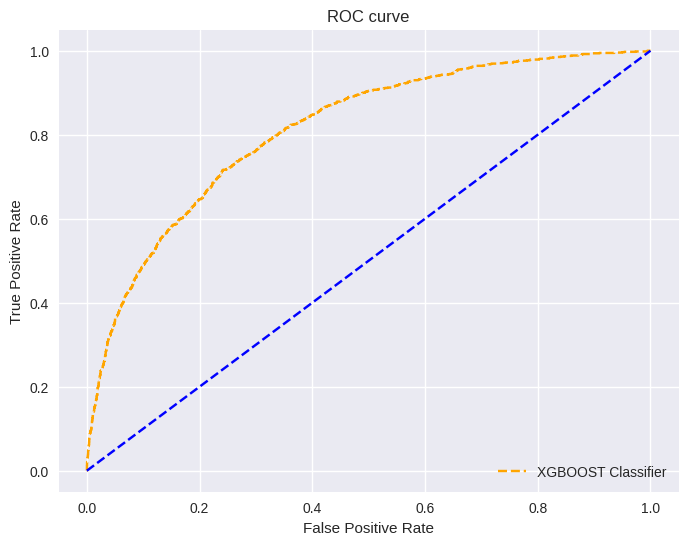

In [ ]:
# Evaluating the model on test dataset

# Transforming the validation data into word2vec format using the same vectorizer
X_w2v_test = np.array([vectorize(sentence) for sentence in test_data.text_preprocessed])

# Changing the label name
y_test = test_data.propaganda_label

# Predicting the labels for test data
pred_test = xg_best.predict(X_w2v_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

###**4. Word2Vec Google News Vector**

In [ ]:
# Selecting the features and the target variables

X = train_data["text_preprocessed"]

y = train_data["propaganda_label"]

In [ ]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

In [ ]:
# Creating train/test list of sentences

train_articles = [sentence.split() for sentence in X_train]
test_articles = [sentence.split() for sentence in X_test]

In [ ]:
%%time

# Path to dataset
word2vec_path = "/content/drive/My Drive/Design Project/GoogleNews-vectors-negative300.bin.gz"

# Load 200,000 most common words
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000)

CPU times: user 3.13 s, sys: 224 ms, total: 3.36 s
Wall time: 4.9 s


In [ ]:
# Get word vector
test_word = w2v_model['election']

# Print shape and vector
print('Vector dimension:', test_word.shape)

Vector dimension: (300,)


In [ ]:
# Query word vectors
word = 'trump'
most_similar_words = w2v_model.most_similar(word)
similarity_score = w2v_model.similarity('trump', 'business')

print(f"Most similar words to '{word}': {most_similar_words}")
print(f"Similarity score between 'trump' and 'business': {similarity_score}")

Most similar words to 'trump': [('trumps', 0.7198434472084045), ('trumping', 0.580585241317749), ('supersede', 0.5600422620773315), ('trumped', 0.5497318506240845), ('supercede', 0.5309919118881226), ('prevail', 0.487763375043869), ('outweigh', 0.47853273153305054), ('trample', 0.4714253544807434), ('overshadow', 0.4701153635978699), ('dictate', 0.46754559874534607)]
Similarity score between 'trump' and 'business': 0.07233818620443344


In [ ]:
w2v_words = list(w2v_model.index_to_key)

print("number of words that occured minimum 5 times ", len(w2v_words))

print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  200000
sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out']


In [ ]:
# Transforming preprocessed text data into Word2Vec encoded features

import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model[word] for word in words if word in w2v_model]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_w2v_train = np.array([vectorize(sentence) for sentence in X_train])
X_w2v_test = np.array([vectorize(sentence) for sentence in X_test])

X_w2v_train.shape, X_w2v_test.shape

((28788, 300), (7198, 300))

In [ ]:
# Transforming categorical column

le = LabelEncoder()
y_train = le.fit_transform(y_train)

              precision    recall  f1-score   support

          -1       0.94      0.98      0.96      6394
           1       0.78      0.51      0.62       804

    accuracy                           0.93      7198
   macro avg       0.86      0.75      0.79      7198
weighted avg       0.92      0.93      0.92      7198



Text(0.5, 1.0, 'Confusion Matrix')

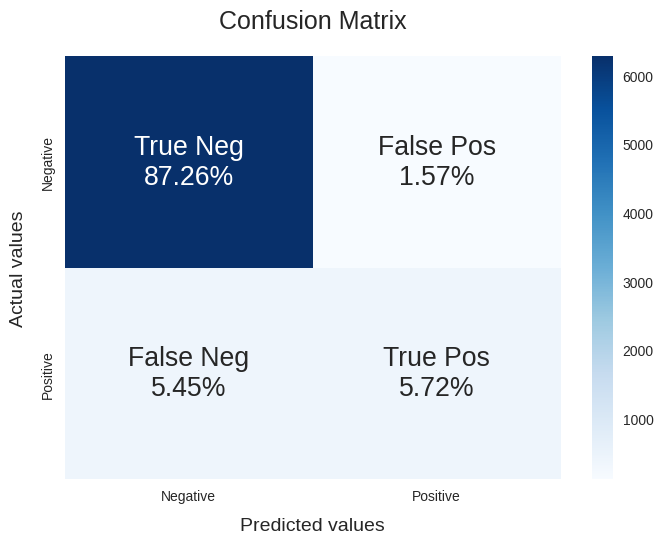

In [ ]:
# XGBOOST classifer without using scale_pos_weight hyperparameter

xgb_clf = XGBClassifier(eval_metric = "auc",
                        n_jobs = -1)

xgb_clf.fit(X_w2v_train, y_train, verbose = False)


# Predict on test data
pred_test = xgb_clf.predict(X_w2v_test)
y_pred = le.inverse_transform(pred_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Estimate: 7.950
              precision    recall  f1-score   support

          -1       0.95      0.97      0.96      6394
           1       0.71      0.63      0.67       804

    accuracy                           0.93      7198
   macro avg       0.83      0.80      0.82      7198
weighted avg       0.93      0.93      0.93      7198



Text(0.5, 1.0, 'Confusion Matrix')

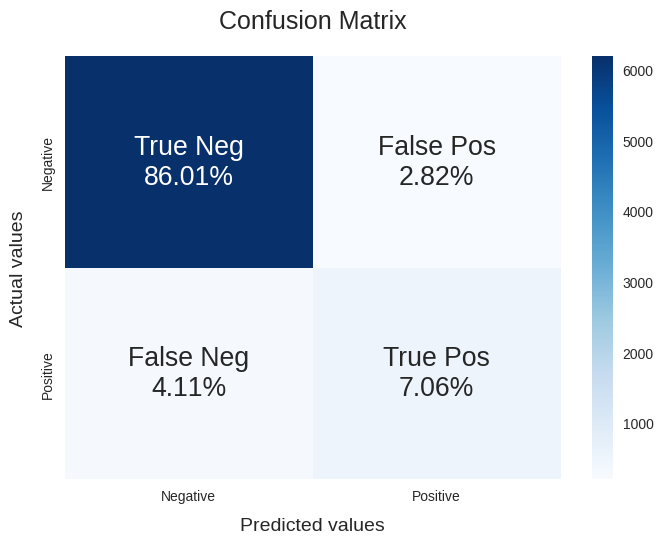

In [ ]:
# XGBOOST classifier using scale_pos_weight hyperparameter

# Counting examples in each class
counter = Counter(y)

# Estimating scale_pos_weight value
estimate = counter[-1] / counter[1]
print('Estimate: %.3f' % estimate)

xgb_clf = XGBClassifier(scale_pos_weight = estimate,
                        eval_metric = "auc",
                        n_jobs = -1)

xgb_clf.fit(X_w2v_train, y_train, verbose = False)


# Predict on test data
pred_test = xgb_clf.predict(X_w2v_test)
y_pred = le.inverse_transform(pred_test)


# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
%%time

# Hyperparameter tuning

# Creating model instance
xgb_clf = XGBClassifier()

# Estimating scale_pos_weight value
estimate = counter[-1] / counter[1]

# specifying all hyperparameters with possible values
param = {
    'scale_pos_weight': [estimate],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [0.1, 0.5, 1, 2, 3, 5, 8, 10],
    'subsample': [0.5, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 5, 10]
}

# Create 5 folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Hyperparameter tuning using RandomizedSearchCV
model = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param, scoring="f1", n_iter=20, cv=folds, verbose=2, n_jobs=-1, return_train_score=True, random_state=50)

# Train model to learn relationships between x and y
model.fit(X_w2v_train, y_train)

# Saving the trained model to a file
model_name = 'googlew2v_tuned_xgboost_model.pkl'
joblib.dump(model,model_name )


# Loading the model
model = joblib.load(model_name)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 1min 21s, sys: 3.08 s, total: 1min 24s
Wall time: 34min 30s


In [ ]:
ls

 best_tfidf_xgboost_model.pkl                                    preprocessed_test_data.csv
'Design Project - ** 1. Pre-Processing.ipynb'                    preprocessed_train_data.csv
'Design Project - ** 2. Feature Engineering   Embedding.ipynb'   preprocessed_valid_data.csv
 Design_Project_Code_2_for_submission_ipynb.ipynb                proppy_1.0.dev.tsv
'google news vectors'                                            proppy_1.0.test.tsv
 GoogleNews-vectors-negative300.bin.gz                           proppy_1.0.train.tsv
 googlew2v_tuned_xgboost_model.pkl                               tuned_xgboost_model.pkl
 model_dir/                                                      w2v_tuned_xgboost_model.pkl
 new_tuned_xgboost_model.pkl


In [ ]:
# printing best hyperparameters

print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.6968076602541899
Best hyperparameters:  {'subsample': 0.7, 'scale_pos_weight': 7.949515046008456, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


In [ ]:
# Building model again with best params

xg_best = XGBClassifier(subsample= 0.7, scale_pos_weight= 7.949515046008456, reg_lambda= 1, reg_alpha= 0.5, n_estimators= 300, min_child_weight= 2, max_depth= 7, learning_rate= 0.1, colsample_bytree= 0.7)

xg_best.fit(X_w2v_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

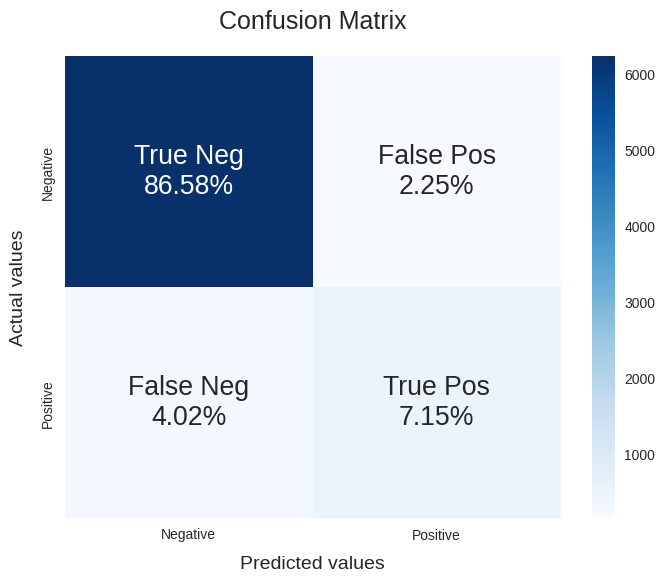



Classification Report

              precision    recall  f1-score   support

          -1       0.96      0.97      0.97      6394
           1       0.76      0.64      0.70       804

    accuracy                           0.94      7198
   macro avg       0.86      0.81      0.83      7198
weighted avg       0.93      0.94      0.93      7198


ROC AUC Score: 0.8076055054723256


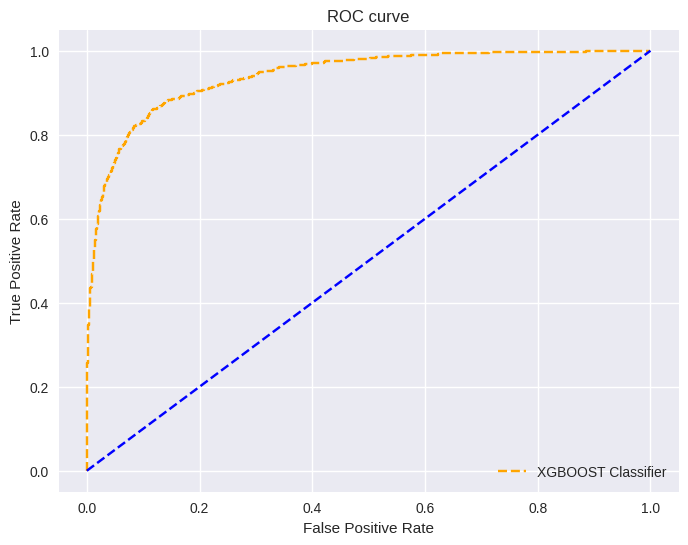

In [ ]:
# Evaluating the model on Training data

# Predicting the labels for train data
pred_test = xg_best.predict(X_w2v_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Checking validation data

valid_data.head()

,text_preprocessed,propaganda_label
0,"convened examine cause civil unrest black communities, presidential commission issued report stark conclusion: america moving towards two societies, ""one black, one white — separate unequal."" fifty year historic kerner commission identified ""white racism"" key cause ""pervasive discrimination employment, education housing,"" progress african american fare comparison white come homeownership, unemployment incarceration, according report economic policy institute released monday. cases, african american worse today civil right movement culminated law barring housing voter discrimination well ra...",-1
1,"discriminating someone basis sexual orientation prohibited federal civil right law, federal appeal court ruled monday sided gay skydiving instructor fired job discussing sexuality client. decision u.s. court appeal 2nd circuit offer expanded protection lgbt people mark significant loss president donald trump justice department, filed brief arguing title vii civil right act cover sexual orientation discrimination. state law still murky, federal circuit part country issued mixed opinions. ruling 2nd circuit, based manhattan, could appealed supreme court. justice department spokesman devin o'...",-1
2,"bill cosby year old daughter, ensa cosby, died massachusetts kidney disease, spokesman comedian said monday. spokesman andrew wyatt immediately offer detail death friday. ""please keep cosby family prayer give peace time,"" said. bill cosby lost another five child year old son, ennis, graduate student columbia university, shot death changing flat tire near freeway ramp los angeles. year old man later convicted sentenced life prison without parole. bill cosby, 80, owns home western massachusetts town shelburne falls. ensa cosby spoke father behalf trial last year charge drugged molested woman...",-1
3,"fast moving, powerful theatrical locomotive “murder orient express” hartford stage march 25, make stop syria, paris snowbound, tree lined landscape between. really want broadway. though character speak host top european accents, patter new york snappy. show’s designer broadway regular — costume designer extraordinaire william ivey long (a natural gig, done recent broadway revival “on twentieth century”), scenic designer beowulf boritt (“come away,” “meteor shower”), lighting designer ken billington (who worked boritt “sunday park george” “act one”), sound designer darron l. west (a regular...",-1
4,"friday. national pizza day. grab life slice. not? connecticut all. footing national pizza lore remains solid ever. hartford, option pie plentiful. new haven, even better — like thin slightly charred. hardest choice, without doubt, go. you’re bold, take tour. half dozen option you’re hartford area: angelina’s hartford. boast biggest slice around. true pizza detective needed investigate claim, likely won’t leave hungry. handout angelina is: prospect ave, hartford, ct angelina is: prospect ave, hartford, ct (handout) couple turn away, you’ve got lena’s first & last pizzaria hartford parkville...",-1


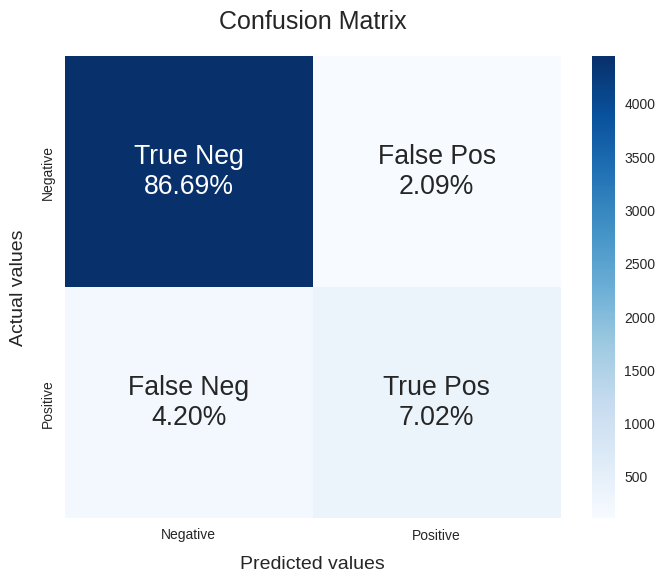



Classification Report

              precision    recall  f1-score   support

          -1       0.95      0.98      0.97      4550
           1       0.77      0.63      0.69       575

    accuracy                           0.94      5125
   macro avg       0.86      0.80      0.83      5125
weighted avg       0.93      0.94      0.93      5125


ROC AUC Score: 0.8012852365026278


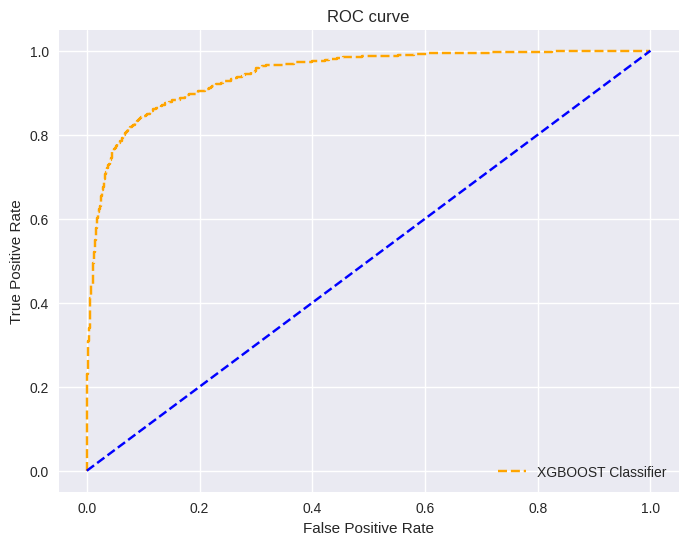

In [ ]:
# Evaluating the model on Validation dataset

# Transforming the validation data into word2vec format using the same vectorizer
X_w2v_test = np.array([vectorize(sentence) for sentence in valid_data.text_preprocessed])

# Changing the label name
y_test = valid_data.propaganda_label


# Predicting the labels for validation data
pred_test = xg_best.predict(X_w2v_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Checking test data

test_data.head()

,text_preprocessed,propaganda_label
0,"eat connecticut teamed end hunger connecticut (ehc) first ever 'culinary corner pub crawl,' jan. 20. crawl featured top blue back square pub restaurants. proceeds benefit ehc program outreach efforts. diner purchased special bracelets, entitled percent discount flora, vinted, india, cook bear, artisan restaurant. participant map stamped venue. jeannette dardenne, co owns eat connecticut, said crawl let community sample food drink west hartford premier restaurant support great cause. dardenne co owner kristen fritz founded social influencer group guide people fun activity supporting local c...",-1
1,"owner old pennsylvania power plant that’s target connecticut anti air pollution lawsuit reached deal sierra club stop burning coal facility peak summer ozone month starting 2023. agreement talen energy, owner high pollution brunner island generating facility, sierra club official halt burning coal power plant may september beginning start phase plan 2023. coal use year old plant ended consent decree, still need court approval. connecticut authority environmental group year demanding federal action clean pollution brunner island steam electric station. cite study showing emission plant drif...",-1
2,"majority owner president donald trump hotel latin america abruptly ordered trump employee property thursday, triggering confrontation trump employee refused leave asked police intervene, according trump organization local news reports. attempt takeover orestes fintiklis — cypriot businessman based miami — marked sharp escalation fintiklis month old effort brand trump international hotel panama replace trump organization manager. fintiklis blame trump brand trump company declining revenue empty rooms. but, far, tactic confined lawsuit angry letters. changed thursday, fintiklis group others ...",-1
3,"connecticut’s likely option using toll help fund transportation project involves “congestion pricing” system charge driver rush hour le peak times, according top state official. state could bring much $750 million year toll revenue using congestion pricing, according transportation commissioner james redeker. warned state commission last month would involve “tolling every interstate limited access [highway] state roads.” way achieve level revenue would put toll state roads, including route 2, 8, merritt parkway, redeker said december hearing commission fiscal stability economic growth. “we...",-1
4,"escaped prisoner jerry mercado back connecticut. year old hartford man escaped carl robinson correctional institution enfield jan. 7. housed northern correctional institution somers, known state’s supermax prison. mercado extradited canton, ga., held since arrest local police jan. 17. initially fought extradition, later waived right. caught, mercado bleached hair eyebrow made effort cover notorious neck tattoo reads: “time wait one.” department correction’s fugitive investigation unit, working concert u.s. marshal fugitive task force connecticut state police, developed intelligence placing...",-1


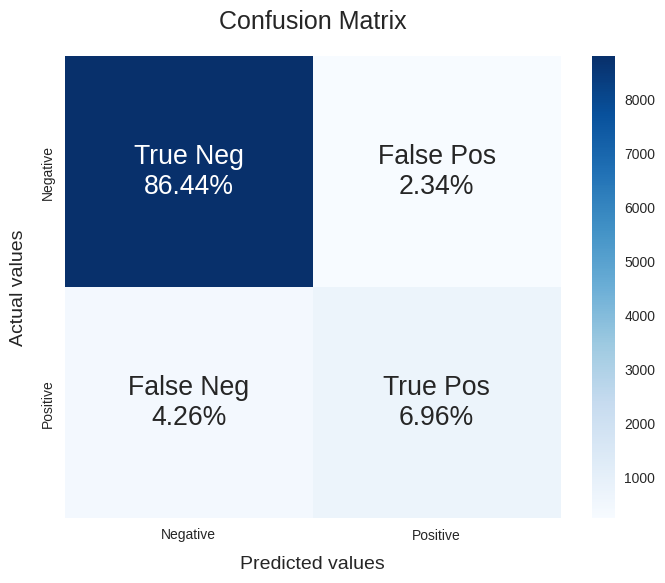



Classification Report

              precision    recall  f1-score   support

          -1       0.95      0.97      0.96      9019
           1       0.75      0.62      0.68      1140

    accuracy                           0.93     10159
   macro avg       0.85      0.80      0.82     10159
weighted avg       0.93      0.93      0.93     10159


ROC AUC Score: 0.7968933518517438


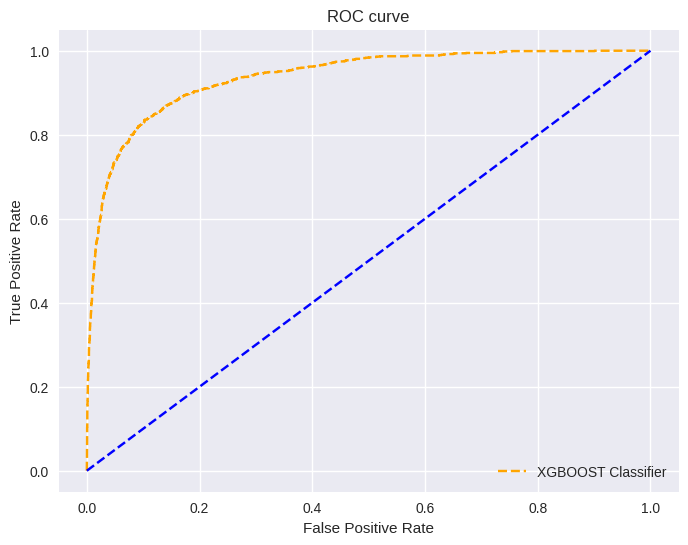

In [ ]:
# Evaluating the model on test dataset

# Transforming the validation data into word2vec format using the same vectorizer
X_w2v_test = np.array([vectorize(sentence) for sentence in test_data.text_preprocessed])

# Changing the label name
y_test = test_data.propaganda_label

# Predicting the labels for test data
pred_test = xg_best.predict(X_w2v_test)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

###**5. LDA**

In [5]:
# Selecting the features and the target variables

X = train_data["text_preprocessed"]
y = train_data["propaganda_label"]

In [6]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

In [7]:
%%time

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Creating a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Applying LDA
num_topics = 5
lda = LatentDirichletAllocation(n_components = num_topics, random_state=50)

X_train_topics = lda.fit_transform(X_train_vec)
X_test_topics = lda.transform(X_test_vec)

# Extracting the topics
topics = lda.components_

CPU times: user 3min 4s, sys: 3.75 s, total: 3min 7s
Wall time: 3min 15s


In [8]:
for topic_idx, topic in enumerate(topics):

    print(f"Topic {topic_idx}: {', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-5:]])}")

Topic 0: china, state, year, trump, said
Topic 1: syria, israeli, state, israel, said
Topic 2: police, time, people, year, said
Topic 3: government, minister, korea, north, said
Topic 4: house, state, president, trump, said


In [9]:
# Transforming the target column

le = LabelEncoder()

y_train = le.fit_transform(y_train)

              precision    recall  f1-score   support

          -1       0.91      0.97      0.94      6394
           1       0.50      0.22      0.30       804

    accuracy                           0.89      7198
   macro avg       0.70      0.60      0.62      7198
weighted avg       0.86      0.89      0.87      7198



Text(0.5, 1.0, 'Confusion Matrix')

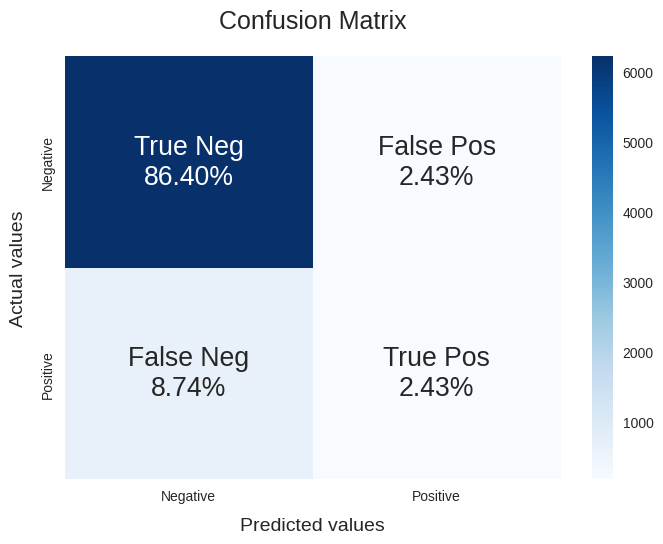

In [10]:
# XGBOOST classifer without using scale_pos_weight hyperparameter

xgb_clf = XGBClassifier(eval_metric = "auc",
                        n_jobs = -1)

xgb_clf.fit(X_train_topics, y_train)


# Predict on test data
pred_test = xgb_clf.predict(X_test_topics)
y_pred = le.inverse_transform(pred_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

          -1       0.95      0.78      0.86      6394
           1       0.28      0.68      0.40       804

    accuracy                           0.77      7198
   macro avg       0.62      0.73      0.63      7198
weighted avg       0.88      0.77      0.81      7198



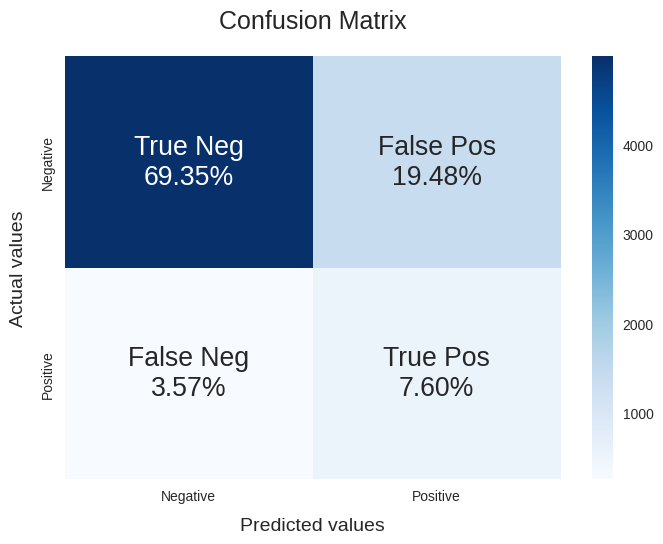

In [11]:
# XGBOOST classifier using scale_pos_weight hyperparameter

from collections import Counter

# Counting examples in each class
counter = Counter(y)

# Estimating scale_pos_weight value
estimate = counter[-1] / counter[1]

xgb_clf = XGBClassifier(scale_pos_weight = estimate,
                        eval_metric = "auc",
                        n_jobs = -1)

xgb_clf.fit(X_train_topics, y_train)


# Predict on test data
pred_test = xgb_clf.predict(X_test_topics)
y_pred = le.inverse_transform(pred_test)


# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [12]:
%%time

# Hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
from tqdm import tqdm  # Import tqdm
import joblib

# Creating model instance
xgb_clf = XGBClassifier()

# Estimating scale_pos_weight value
estimate = counter[-1] / counter[1]

# specifying all hyperparameters with possible values
param = {
    'scale_pos_weight': [estimate],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [0.1, 0.5, 1, 2, 3, 5, 8, 10],
    'subsample': [0.5, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300,500],
    'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 5, 10]
}

# Create 5 folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Hyperparameter tuning using RandomizedSearchCV
model = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param, scoring="f1", n_iter=20, cv=folds, verbose=2, n_jobs=-1, return_train_score=True, random_state=50)

# Train model to learn relationships between x and y
model.fit(X_train_topics, y_train)

# Saving the trained model to a file
model_name = 'LDA_tuned_xgboost_model.pkl'
joblib.dump(model,model_name )

# Loading the model
model = joblib.load(model_name)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 3.14 s, sys: 193 ms, total: 3.33 s
Wall time: 1min 15s


In [13]:
# printing best hyperparameters

print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.40622078318034516
Best hyperparameters:  {'subsample': 0.8, 'scale_pos_weight': 7.949515046008456, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


In [14]:
# Building model again with best params

xg_best = XGBClassifier(subsample= 0.8, scale_pos_weight= 7.949515046008456, reg_lambda= 10, reg_alpha= 1, n_estimators= 300, min_child_weight= 1, max_depth= 10, learning_rate= 0.1, colsample_bytree= 0.5)

xg_best.fit(X_train_topics, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

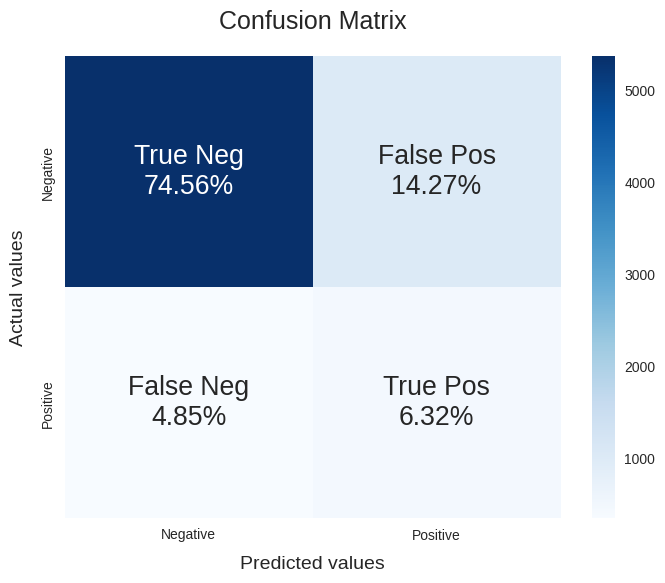



Classification Report

              precision    recall  f1-score   support

          -1       0.94      0.84      0.89      6394
           1       0.31      0.57      0.40       804

    accuracy                           0.81      7198
   macro avg       0.62      0.70      0.64      7198
weighted avg       0.87      0.81      0.83      7198


ROC AUC Score: 0.7026505336937457


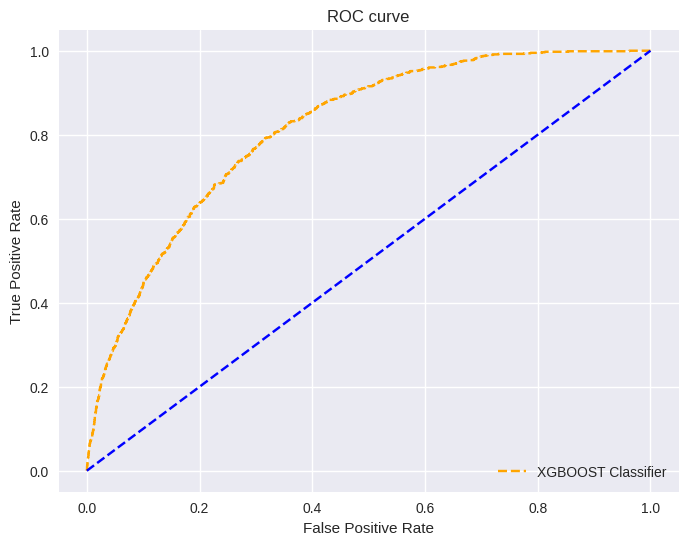

In [15]:
# Evaluating the model on Training data

# Predicting the labels for train data
pred_test = xg_best.predict(X_test_topics)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_test_topics)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [16]:
# Checking validation data

valid_data.head()

,text_preprocessed,propaganda_label
0,"convened examine cause civil unrest black communities, presidential commission issued report stark conclusion: america moving towards two societies, ""one black, one white — separate unequal."" fifty year historic kerner commission identified ""white racism"" key cause ""pervasive discrimination employment, education housing,"" progress african american fare comparison white come homeownership, unemployment incarceration, according report economic policy institute released monday. cases, african american worse today civil right movement culminated law barring housing voter discrimination well ra...",-1
1,"discriminating someone basis sexual orientation prohibited federal civil right law, federal appeal court ruled monday sided gay skydiving instructor fired job discussing sexuality client. decision u.s. court appeal 2nd circuit offer expanded protection lgbt people mark significant loss president donald trump justice department, filed brief arguing title vii civil right act cover sexual orientation discrimination. state law still murky, federal circuit part country issued mixed opinions. ruling 2nd circuit, based manhattan, could appealed supreme court. justice department spokesman devin o'...",-1
2,"bill cosby year old daughter, ensa cosby, died massachusetts kidney disease, spokesman comedian said monday. spokesman andrew wyatt immediately offer detail death friday. ""please keep cosby family prayer give peace time,"" said. bill cosby lost another five child year old son, ennis, graduate student columbia university, shot death changing flat tire near freeway ramp los angeles. year old man later convicted sentenced life prison without parole. bill cosby, 80, owns home western massachusetts town shelburne falls. ensa cosby spoke father behalf trial last year charge drugged molested woman...",-1
3,"fast moving, powerful theatrical locomotive “murder orient express” hartford stage march 25, make stop syria, paris snowbound, tree lined landscape between. really want broadway. though character speak host top european accents, patter new york snappy. show’s designer broadway regular — costume designer extraordinaire william ivey long (a natural gig, done recent broadway revival “on twentieth century”), scenic designer beowulf boritt (“come away,” “meteor shower”), lighting designer ken billington (who worked boritt “sunday park george” “act one”), sound designer darron l. west (a regular...",-1
4,"friday. national pizza day. grab life slice. not? connecticut all. footing national pizza lore remains solid ever. hartford, option pie plentiful. new haven, even better — like thin slightly charred. hardest choice, without doubt, go. you’re bold, take tour. half dozen option you’re hartford area: angelina’s hartford. boast biggest slice around. true pizza detective needed investigate claim, likely won’t leave hungry. handout angelina is: prospect ave, hartford, ct angelina is: prospect ave, hartford, ct (handout) couple turn away, you’ve got lena’s first & last pizzaria hartford parkville...",-1


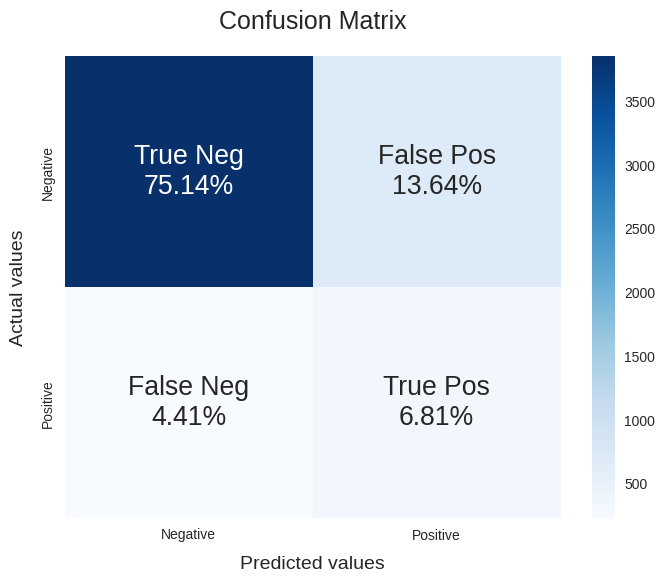



Classification Report

              precision    recall  f1-score   support

          -1       0.94      0.85      0.89      4550
           1       0.33      0.61      0.43       575

    accuracy                           0.82      5125
   macro avg       0.64      0.73      0.66      5125
weighted avg       0.88      0.82      0.84      5125


ROC AUC Score: 0.7266650740563784


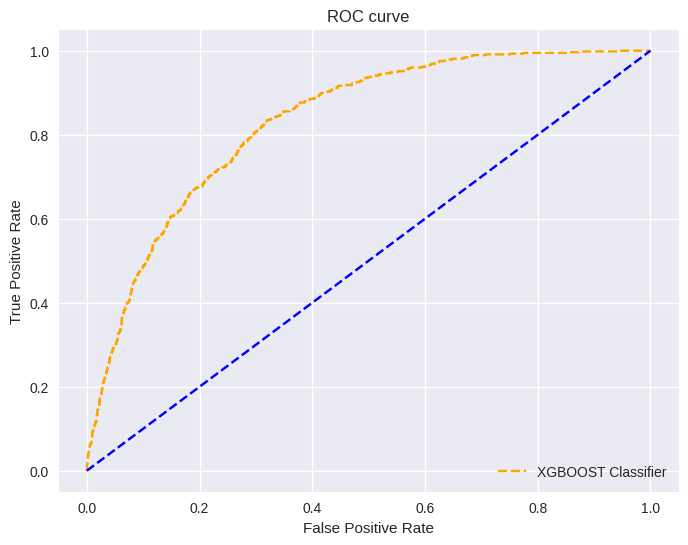

In [17]:
# Evaluating the model on Validation dataset

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Transforming the validation data into LDA format using the same vectorizer
X_test_vec = vectorizer.transform(valid_data.text_preprocessed)
X_test_topics = lda.transform(X_test_vec)



# Changing the label name
y_test = valid_data.propaganda_label


# Predicting the labels for validation data
pred_test = xg_best.predict(X_test_topics)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_test_topics)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [18]:
# Checking test data

test_data.head()

,text_preprocessed,propaganda_label
0,"eat connecticut teamed end hunger connecticut (ehc) first ever 'culinary corner pub crawl,' jan. 20. crawl featured top blue back square pub restaurants. proceeds benefit ehc program outreach efforts. diner purchased special bracelets, entitled percent discount flora, vinted, india, cook bear, artisan restaurant. participant map stamped venue. jeannette dardenne, co owns eat connecticut, said crawl let community sample food drink west hartford premier restaurant support great cause. dardenne co owner kristen fritz founded social influencer group guide people fun activity supporting local c...",-1
1,"owner old pennsylvania power plant that’s target connecticut anti air pollution lawsuit reached deal sierra club stop burning coal facility peak summer ozone month starting 2023. agreement talen energy, owner high pollution brunner island generating facility, sierra club official halt burning coal power plant may september beginning start phase plan 2023. coal use year old plant ended consent decree, still need court approval. connecticut authority environmental group year demanding federal action clean pollution brunner island steam electric station. cite study showing emission plant drif...",-1
2,"majority owner president donald trump hotel latin america abruptly ordered trump employee property thursday, triggering confrontation trump employee refused leave asked police intervene, according trump organization local news reports. attempt takeover orestes fintiklis — cypriot businessman based miami — marked sharp escalation fintiklis month old effort brand trump international hotel panama replace trump organization manager. fintiklis blame trump brand trump company declining revenue empty rooms. but, far, tactic confined lawsuit angry letters. changed thursday, fintiklis group others ...",-1
3,"connecticut’s likely option using toll help fund transportation project involves “congestion pricing” system charge driver rush hour le peak times, according top state official. state could bring much $750 million year toll revenue using congestion pricing, according transportation commissioner james redeker. warned state commission last month would involve “tolling every interstate limited access [highway] state roads.” way achieve level revenue would put toll state roads, including route 2, 8, merritt parkway, redeker said december hearing commission fiscal stability economic growth. “we...",-1
4,"escaped prisoner jerry mercado back connecticut. year old hartford man escaped carl robinson correctional institution enfield jan. 7. housed northern correctional institution somers, known state’s supermax prison. mercado extradited canton, ga., held since arrest local police jan. 17. initially fought extradition, later waived right. caught, mercado bleached hair eyebrow made effort cover notorious neck tattoo reads: “time wait one.” department correction’s fugitive investigation unit, working concert u.s. marshal fugitive task force connecticut state police, developed intelligence placing...",-1


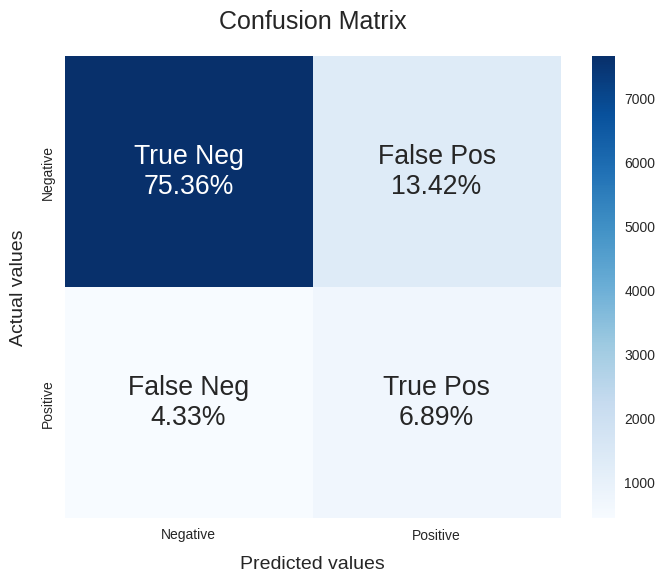



Classification Report

              precision    recall  f1-score   support

          -1       0.95      0.85      0.89      9019
           1       0.34      0.61      0.44      1140

    accuracy                           0.82     10159
   macro avg       0.64      0.73      0.67     10159
weighted avg       0.88      0.82      0.84     10159


ROC AUC Score: 0.7314548428950189


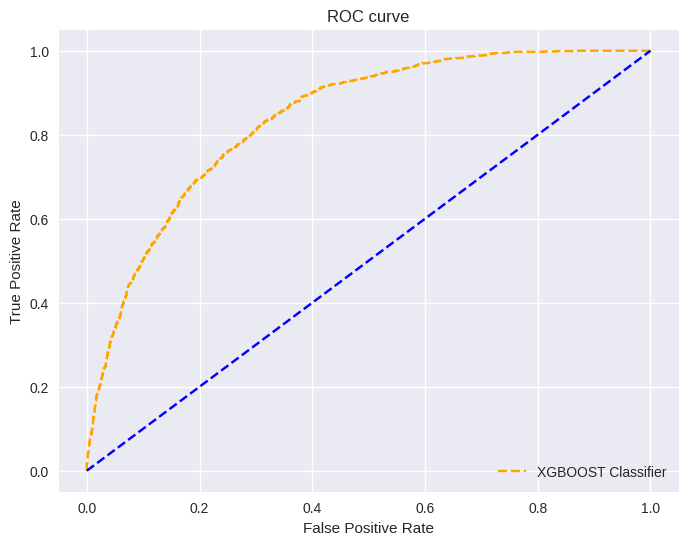

In [19]:
# Evaluating the model on test dataset

# Transforming the test data into LDA format using the same vectorizer and then applying LDA
X_test_vec = vectorizer.transform(test_data.text_preprocessed)
X_test_topics = lda.transform(X_test_vec)

# Changing the label name
y_test = test_data.propaganda_label

# Predicting the labels for test data
pred_test = xg_best.predict(X_test_topics)
y_pred = le.inverse_transform(pred_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Getting probabilities
y_pred_proba = xg_best.predict_proba(X_test_topics)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBOOST Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [20]:
# Using Prettytable for displaying the observations

from prettytable import PrettyTable

table = PrettyTable()

table.field_names = ["S.No","Model", "Vectorizer", "Hyper Parameters", "Accuracy", "F1 - Negative Class(-1)","F1 - Positive Class(1)","AUC Score"]

print(table)

+------+-------+------------+------------------+----------+-------------------------+------------------------+-----------+
| S.No | Model | Vectorizer | Hyper Parameters | Accuracy | F1 - Negative Class(-1) | F1 - Positive Class(1) | AUC Score |
+------+-------+------------+------------------+----------+-------------------------+------------------------+-----------+
+------+-------+------------+------------------+----------+-------------------------+------------------------+-----------+


In [21]:
## Adding rows to the table

table.add_row([1,"XGBoost", "Bag Of Words", "'subsample': 0.9, 'scale_pos_weight': 7.94, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.7", 0.96, 0.98, 0.83, 0.88])
table.add_row([2,"XGBoost", "TF-IDF", "'subsample': 0.8, 'scale_pos_weight': 7.94, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9", 0.96, 0.98, 0.82, 0.87])
table.add_row([3,"XGBoost", "Word2Vec", "'subsample': 0.7, 'scale_pos_weight': 7.94, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9", 0.81, 0.88, 0.41, 0.71])
table.add_row([4,"XGBoost", "Google News Vectors - Word2Vec", "'subsample': 0.7, 'scale_pos_weight': 7.94, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7", 0.93, 0.96, 0.68, 0.79])
table.add_row([5,"XGBoost", "LDA", "'subsample': 0.8, 'scale_pos_weight': 7.94, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5", 0.82, 0.89, 0.44, 0.73])

In [22]:
print(table)

+------+---------+--------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-------------------------+------------------------+-----------+
| S.No |  Model  |           Vectorizer           |                                                                                      Hyper Parameters                                                                                     | Accuracy | F1 - Negative Class(-1) | F1 - Positive Class(1) | AUC Score |
+------+---------+--------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-------------------------+------------------------+-----------+
|  1   | XGBoost |          Bag Of Words          | 'subsa

##**Heat Map - Performance of all the Vectorizers**

In [26]:
import pandas as pd
import plotly.express as px

data = {
    "S.No": [1, 2, 3, 4, 5],
    "Model": ["XGBoost"] * 5,
    "Vectorizer": ["Bag Of Words", "TF-IDF", "Word2Vec", "Google News Vectors - Word2Vec", "LDA"],
    "Hyper Parameters": [
        "'subsample': 0.9, 'scale_pos_weight': 7.94, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.7",
        "'subsample': 0.8, 'scale_pos_weight': 7.94, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9",
        "'subsample': 0.7, 'scale_pos_weight': 7.94, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9",
        "'subsample': 0.7, 'scale_pos_weight': 7.94, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7",
        "'subsample': 0.8, 'scale_pos_weight': 7.94, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5 "
    ],
    "Accuracy": [0.96, 0.96, 0.81, 0.93, 0.82],
    "F1 - Negative Class(-1)": [0.98, 0.99, 0.88, 0.96, 0.89],
    "F1 - Positive Class(1)": [0.83, 0.82, 0.41, 0.68, 0.44],
    "AUC Score": [0.88, 0.87, 0.71, 0.79, 0.73]
}

df = pd.DataFrame(data)

# Create an annotated heatmap using Plotly
fig = px.imshow(
    df.drop(["S.No", "Model", "Vectorizer", "Hyper Parameters"], axis=1),
    labels=dict(x="Metrics", y="Models", color="Value"),
    x=df.columns[4:],  # Excluding non-numeric columns
    y=df.Vectorizer,
    color_continuous_scale="Tealgrn",
    title="XGBoost Performance",
)

# Add text annotations to the heatmap with respective column values
for i in range(len(df.Vectorizer)):
    for j in range(len(df.columns[4:])):
        value = df.iloc[i, j + 4]  # Use j+4 to access the actual value in the DataFrame
        fig.add_annotation(
            text=str(value),
            x=df.columns[4:][j],
            y=df.Vectorizer.iloc[i],
            showarrow=False,
            font=dict(color="white"),  # Font color for text annotations
        )

fig.update_layout(
    xaxis_title="Metrics",
    yaxis_title="Vectorizer",
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    autosize=False,
    width=1200,  # Adjust the width as needed
    height=800,  # Adjust the height as needed
)

fig.show()

##**Animated bubble plot showing ROC scores**

In [24]:
import plotly.express as px
import pandas as pd

data = {
    "Model": ["XGBoost"] * 5,
    "Vectorizer": ["Bag Of Words", "TF-IDF", "Word2Vec", "Google News Vectors - Word2Vec", "LDA"],
    "ROC Score": [0.88, 0.87, 0.71, 0.79, 0.73],
    "Hyper Parameters": ["'subsample': 0.9, 'scale_pos_weight': 7.94, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.7",
        "'subsample': 0.8, 'scale_pos_weight': 7.94, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9",
        "'subsample': 0.7, 'scale_pos_weight': 7.94, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9",
        "'subsample': 0.7, 'scale_pos_weight': 7.94, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7",
        "'subsample': 0.8, 'scale_pos_weight': 7.94, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5 "
   ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create the animated bubble plot
fig = px.scatter(df, x="Model", y="ROC Score", animation_frame="Vectorizer",
                 color="Vectorizer", size="ROC Score", text="ROC Score",
                 title="ROC Score vs. Vectorizer (Animated)", labels={"ROC Score": "ROC Score"})

# Customize the appearance of the plot
fig.update_traces(marker=dict(sizemode='diameter'), selector=dict(mode='markers+text'))
fig.update_xaxes(categoryorder='total descending')

# Show the animated bubble plot
fig.show()

##**Line Plot displaying ROC scores**

In [25]:
import plotly.express as px
import pandas as pd

data = {
    "Model": ["XGBoost"] * 5,
    "Vectorizer": ["Bag Of Words", "TF-IDF", "Word2Vec", "Google News Vectors - Word2Vec", "LDA"],
    "ROC Score": [0.88, 0.87, 0.71, 0.79, 0.73],
    "Hyper Parameters": ["'subsample': 0.9, 'scale_pos_weight': 7.94, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.7",
        "'subsample': 0.8, 'scale_pos_weight': 7.94, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9",
        "'subsample': 0.7, 'scale_pos_weight': 7.94, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9",
        "'subsample': 0.7, 'scale_pos_weight': 7.94, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7",
        "'subsample': 0.8, 'scale_pos_weight': 7.94, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5 "
   ]
}
# Create a DataFrame
df = pd.DataFrame(data)

# Create the line plot
fig = px.line(df, x="Vectorizer", y="ROC Score", color="Model", text="ROC Score",
              title="ROC Score vs. Vectorizer (Lines by Model)",
              labels={"ROC Score": "ROC Score", "Vectorizer": "Vectorizer", "Model": "Model"})

# Customize the text position
fig.update_traces(textposition='top center')

# Show the line plot
fig.show()
